# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric, EmbeddingCosineSimilarityAndDistanceLossMetric
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
# reset_first_layer(embedding_net)
replace_last_layer(embedding_net, 2)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
# loss_fn = MultiSiameseCosineSimilarityLoss()
loss_fn = SoftMultiSiameseCosineSimilarityLoss()
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_sim_length_2"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)

## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

KeyboardInterrupt: 

### Angio sequence soft multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
max_cycles_for_pairs = 0
sequence = 3
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_path, max_cycles_for_pairs, sequence, 1000, 64)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [ ]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

Starting Epoch 0
Will sample from train_loader
Train: [5300/1000 (10%)]	Loss: 0.678587	Elapsed time: 0:00:43.900094	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.445, 0.233)	FCWeights (Diff, Avg, Total): (0.2534532845020294, 0.024806682020425797, 101.60816955566406)
Train: [5800/1000 (20%)]	Loss: 0.564767	Elapsed time: 0:01:25.348028	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.442, 0.179)	FCWeights (Diff, Avg, Total): (0.3594038486480713, 0.024636467918753624, 100.91097259521484)
Train: [18000/1000 (30%)]	Loss: 0.520528	Elapsed time: 0:02:07.683138	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.427, 0.161)	FCWeights (Diff, Avg, Total): (0.3596244156360626, 0.024521544575691223, 100.44024658203125)
Train: [25600/1000 (40%)]	Loss: 0.509619	Elapsed time: 0:02:48.618421	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.414, 0.153)	FCWeights (Diff, Avg, Total): (0.4172425866127014, 0.02435937710106373, 99.7760086059570

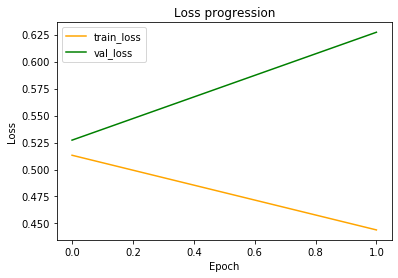

Starting Epoch 2
Will sample from train_loader
Train: [6300/1000 (10%)]	Loss: 0.403348	Elapsed time: 0:00:40.547092	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.323, 0.079)	FCWeights (Diff, Avg, Total): (0.13810260593891144, 0.023121776059269905, 94.70679473876953)
Train: [12800/1000 (20%)]	Loss: 0.425408	Elapsed time: 0:01:21.741974	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.333, 0.08)	FCWeights (Diff, Avg, Total): (0.40129104256629944, 0.023000359535217285, 94.20947265625)
Train: [19200/1000 (30%)]	Loss: 0.418082	Elapsed time: 0:02:03.389713	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.334, 0.08)	FCWeights (Diff, Avg, Total): (0.12749473750591278, 0.022988449782133102, 94.16069030761719)
Train: [18800/1000 (40%)]	Loss: 0.363404	Elapsed time: 0:02:45.172410	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.33, 0.071)	FCWeights (Diff, Avg, Total): (0.3944797217845917, 0.02301839180290699, 94.28333282470703)
Tr

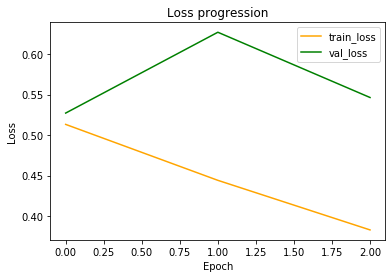

Starting Epoch 3
Will sample from train_loader
Train: [2900/1000 (10%)]	Loss: 0.337946	Elapsed time: 0:00:42.462335	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.285, 0.052)	FCWeights (Diff, Avg, Total): (0.1734195351600647, 0.022754013538360596, 93.200439453125)
Train: [12800/1000 (20%)]	Loss: 0.338442	Elapsed time: 0:01:22.475596	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.28, 0.057)	FCWeights (Diff, Avg, Total): (0.6931256055831909, 0.02270626276731491, 93.00485229492188)
Train: [18000/1000 (30%)]	Loss: 0.352399	Elapsed time: 0:02:04.043570	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.281, 0.061)	FCWeights (Diff, Avg, Total): (0.1977081000804901, 0.022709891200065613, 93.01971435546875)
Train: [17600/1000 (40%)]	Loss: 0.322632	Elapsed time: 0:02:46.010519	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.28, 0.057)	FCWeights (Diff, Avg, Total): (0.20607788860797882, 0.022699736058712006, 92.97811889648438)
Tr

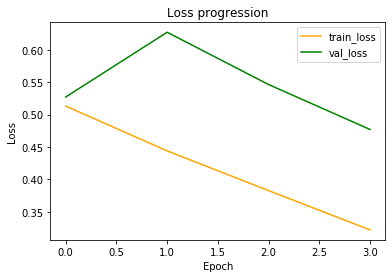

Starting Epoch 4
Will sample from train_loader
Train: [5000/1000 (10%)]	Loss: 0.267063	Elapsed time: 0:00:42.077826	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.251, 0.015)	FCWeights (Diff, Avg, Total): (0.07960058748722076, 0.022663354873657227, 92.8291015625)
Train: [12800/1000 (20%)]	Loss: 0.254374	Elapsed time: 0:01:22.954435	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.247, 0.013)	FCWeights (Diff, Avg, Total): (0.00615792628377676, 0.022663990035653114, 92.83170318603516)
Train: [12900/1000 (30%)]	Loss: 0.252626	Elapsed time: 0:02:03.931808	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.245, 0.012)	FCWeights (Diff, Avg, Total): (0.06096674129366875, 0.022669026628136635, 92.85233306884766)
Train: [19600/1000 (40%)]	Loss: 0.247114	Elapsed time: 0:02:44.080746	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.243, 0.011)	FCWeights (Diff, Avg, Total): (0.03087921440601349, 0.022673364728689194, 92.87010192871094

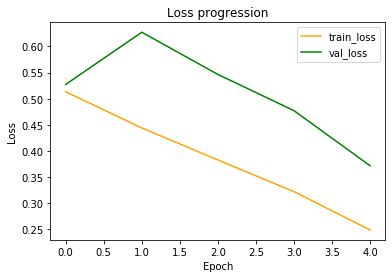

Starting Epoch 5
Will sample from train_loader
Train: [5000/1000 (10%)]	Loss: 0.237524	Elapsed time: 0:00:42.163077	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.228, 0.008)	FCWeights (Diff, Avg, Total): (0.04445576295256615, 0.022711744531989098, 93.02730560302734)
Train: [9800/1000 (20%)]	Loss: 0.238857	Elapsed time: 0:01:24.625703	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.228, 0.009)	FCWeights (Diff, Avg, Total): (0.05546274781227112, 0.022713784128427505, 93.03565979003906)
Train: [18900/1000 (30%)]	Loss: 0.236283	Elapsed time: 0:02:06.793797	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.228, 0.009)	FCWeights (Diff, Avg, Total): (0.05168053135275841, 0.02271546795964241, 93.04255676269531)
Train: [15600/1000 (40%)]	Loss: 0.234939	Elapsed time: 0:02:48.163921	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.227, 0.009)	FCWeights (Diff, Avg, Total): (0.00405832240357995, 0.022720353677868843, 93.062568664550

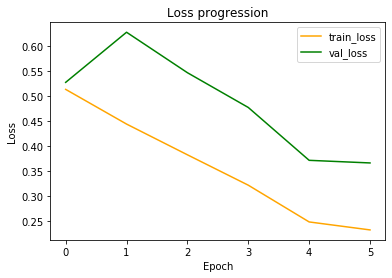

Starting Epoch 6
Will sample from train_loader
Train: [4600/1000 (10%)]	Loss: 0.229095	Elapsed time: 0:00:42.586557	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.219, 0.009)	FCWeights (Diff, Avg, Total): (0.04674107953906059, 0.022747959941625595, 93.17564392089844)
Train: [9400/1000 (20%)]	Loss: 0.227135	Elapsed time: 0:01:25.171517	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.218, 0.009)	FCWeights (Diff, Avg, Total): (0.02976638823747635, 0.022750845178961754, 93.18746185302734)
Train: [13500/1000 (30%)]	Loss: 0.224436	Elapsed time: 0:02:06.269751	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.218, 0.008)	FCWeights (Diff, Avg, Total): (0.039508309215307236, 0.02275707572698593, 93.21298217773438)
Train: [25600/1000 (40%)]	Loss: 0.227046	Elapsed time: 0:02:48.014787	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.217, 0.009)	FCWeights (Diff, Avg, Total): (0.056296445429325104, 0.022758813574910164, 93.2201004028

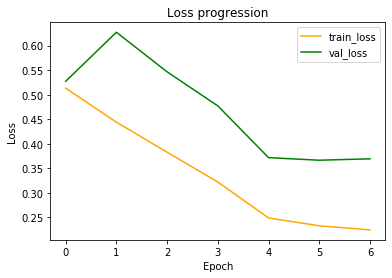

Starting Epoch 7
Will sample from train_loader
Train: [3900/1000 (10%)]	Loss: 0.222598	Elapsed time: 0:00:42.209701	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.212, 0.009)	FCWeights (Diff, Avg, Total): (0.07135595381259918, 0.022772617638111115, 93.27664184570312)
Train: [7800/1000 (20%)]	Loss: 0.225019	Elapsed time: 0:01:22.076054	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.213, 0.009)	FCWeights (Diff, Avg, Total): (0.007366131991147995, 0.022772708907723427, 93.27701568603516)
Train: [19200/1000 (30%)]	Loss: 0.220952	Elapsed time: 0:02:04.180699	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.213, 0.009)	FCWeights (Diff, Avg, Total): (0.012198099866509438, 0.022778935730457306, 93.30252075195312)
Train: [18800/1000 (40%)]	Loss: 0.221109	Elapsed time: 0:02:46.007640	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.213, 0.009)	FCWeights (Diff, Avg, Total): (0.04033508896827698, 0.022781923413276672, 93.314758300

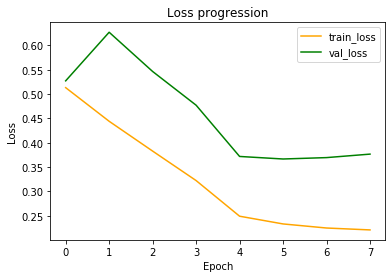

Starting Epoch 8
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.219922	Elapsed time: 0:00:42.963380	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.211, 0.008)	FCWeights (Diff, Avg, Total): (0.015346188098192215, 0.022796910256147385, 93.37614440917969)
Train: [5800/1000 (20%)]	Loss: 0.218927	Elapsed time: 0:01:24.386733	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.21, 0.009)	FCWeights (Diff, Avg, Total): (0.008958385325968266, 0.02280159294605255, 93.39532470703125)
Train: [19200/1000 (30%)]	Loss: 0.221087	Elapsed time: 0:02:05.726706	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.21, 0.009)	FCWeights (Diff, Avg, Total): (0.03387298807501793, 0.022806759923696518, 93.41648864746094)
Train: [25600/1000 (40%)]	Loss: 0.220720	Elapsed time: 0:02:46.762929	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.21, 0.009)	FCWeights (Diff, Avg, Total): (0.05663052946329117, 0.022804316133260727, 93.4064788818359

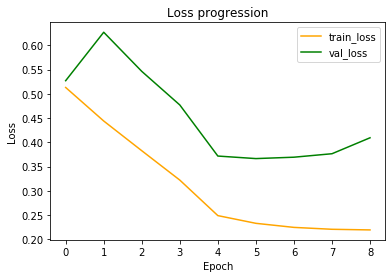

Starting Epoch 9
Will sample from train_loader
Train: [4600/1000 (10%)]	Loss: 0.213683	Elapsed time: 0:00:42.594718	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.208, 0.005)	FCWeights (Diff, Avg, Total): (0.002102622529491782, 0.022818684577941895, 93.46533203125)
Train: [7800/1000 (20%)]	Loss: 0.211095	Elapsed time: 0:01:23.362858	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.207, 0.004)	FCWeights (Diff, Avg, Total): (0.008645683526992798, 0.022819362580776215, 93.46810913085938)
Train: [15600/1000 (30%)]	Loss: 0.209116	Elapsed time: 0:02:04.057960	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.206, 0.004)	FCWeights (Diff, Avg, Total): (0.0034668478183448315, 0.022820336744189262, 93.47209930419922)
Train: [20800/1000 (40%)]	Loss: 0.209177	Elapsed time: 0:02:46.229643	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.206, 0.004)	FCWeights (Diff, Avg, Total): (0.0067889504134655, 0.022821418941020966, 93.47653198242

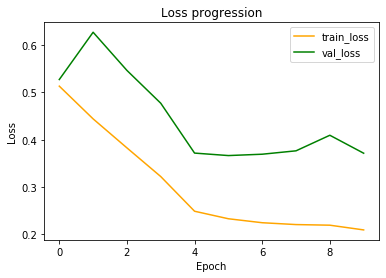

Starting Epoch 10
Will sample from train_loader
Train: [4300/1000 (10%)]	Loss: 0.207310	Elapsed time: 0:00:41.381935	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.007377458270639181, 0.022826503962278366, 93.49736022949219)
Train: [11600/1000 (20%)]	Loss: 0.206793	Elapsed time: 0:01:22.320953	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.00605775648728013, 0.022827602922916412, 93.50186157226562)
Train: [19200/1000 (30%)]	Loss: 0.206770	Elapsed time: 0:02:03.552027	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.004944422282278538, 0.02282821759581566, 93.50437927246094)
Train: [19600/1000 (40%)]	Loss: 0.206810	Elapsed time: 0:02:44.679194	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.005655637010931969, 0.022829387336969376, 93.5091705

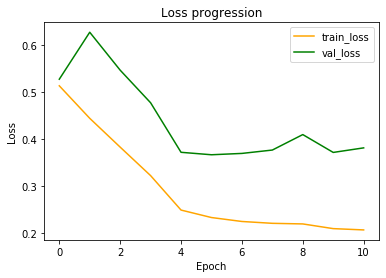

Starting Epoch 11
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.205464	Elapsed time: 0:00:41.675864	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0030481736175715923, 0.022833772003650665, 93.52713012695312)
Train: [9800/1000 (20%)]	Loss: 0.206562	Elapsed time: 0:01:22.975325	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.003)	FCWeights (Diff, Avg, Total): (0.006233613006770611, 0.022834448143839836, 93.52989959716797)
Train: [19200/1000 (30%)]	Loss: 0.207883	Elapsed time: 0:02:05.036355	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.008291417732834816, 0.022835470736026764, 93.53408813476562)
Train: [25600/1000 (40%)]	Loss: 0.206274	Elapsed time: 0:02:47.959252	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.007680308073759079, 0.02283589169383049, 93.535812

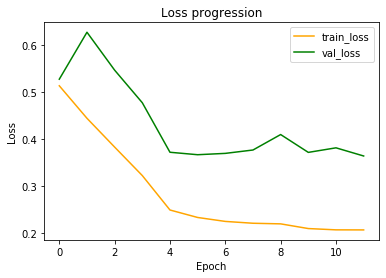

Starting Epoch 12
Will sample from train_loader
Train: [4900/1000 (10%)]	Loss: 0.205634	Elapsed time: 0:00:42.068681	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.003)	FCWeights (Diff, Avg, Total): (0.0042079733684659, 0.022841256111860275, 93.55778503417969)
Train: [12800/1000 (20%)]	Loss: 0.206433	Elapsed time: 0:01:23.801202	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.203, 0.003)	FCWeights (Diff, Avg, Total): (0.006330115254968405, 0.02284212037920952, 93.56132507324219)
Train: [14400/1000 (30%)]	Loss: 0.205826	Elapsed time: 0:02:05.387096	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.003)	FCWeights (Diff, Avg, Total): (0.002846835646778345, 0.022842150181531906, 93.56144714355469)
Train: [20000/1000 (40%)]	Loss: 0.205050	Elapsed time: 0:02:47.057216	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0009832009673118591, 0.022843249142169952, 93.5659484

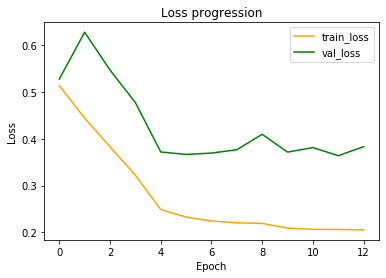

Starting Epoch 13
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.203800	Elapsed time: 0:00:41.663054	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.010097673162817955, 0.02284839190542698, 93.5870132446289)
Train: [12600/1000 (20%)]	Loss: 0.204744	Elapsed time: 0:01:23.202043	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0029481041710823774, 0.02284841239452362, 93.58709716796875)
Train: [19200/1000 (30%)]	Loss: 0.206642	Elapsed time: 0:02:05.409380	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0075429934076964855, 0.022849097847938538, 93.58990478515625)
Train: [25600/1000 (40%)]	Loss: 0.205164	Elapsed time: 0:02:47.549334	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.002888801507651806, 0.0228501558303833, 93.59423828

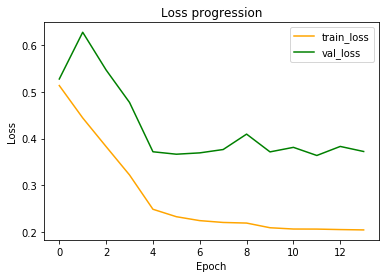

Starting Epoch 14
Will sample from train_loader
Train: [4700/1000 (10%)]	Loss: 0.203973	Elapsed time: 0:00:41.678145	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0002672904811333865, 0.022853493690490723, 93.60791015625)
Train: [10400/1000 (20%)]	Loss: 0.204347	Elapsed time: 0:01:23.060645	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0009250487782992423, 0.022853434085845947, 93.607666015625)
Train: [11700/1000 (30%)]	Loss: 0.203759	Elapsed time: 0:02:04.642123	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0005461547407321632, 0.022853435948491096, 93.60767364501953)
Train: [15600/1000 (40%)]	Loss: 0.203412	Elapsed time: 0:02:46.012508	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.00021295750048011541, 0.022853609174489975, 93.60838

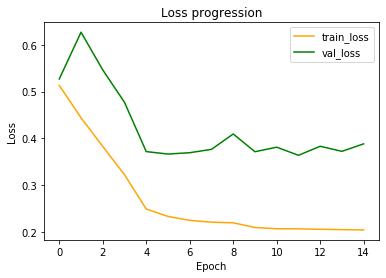

Starting Epoch 15
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.203987	Elapsed time: 0:00:41.645049	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0008642972679808736, 0.022854048758745193, 93.61018371582031)
Train: [8600/1000 (20%)]	Loss: 0.203392	Elapsed time: 0:01:23.065773	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.001)	FCWeights (Diff, Avg, Total): (0.0010590620804578066, 0.022854000329971313, 93.6099853515625)
Train: [19200/1000 (30%)]	Loss: 0.204591	Elapsed time: 0:02:04.308970	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0009610771667212248, 0.022854134440422058, 93.61053466796875)
Train: [20000/1000 (40%)]	Loss: 0.202809	Elapsed time: 0:02:45.511596	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.001)	FCWeights (Diff, Avg, Total): (0.0003771025803871453, 0.02285398542881012, 93.6099

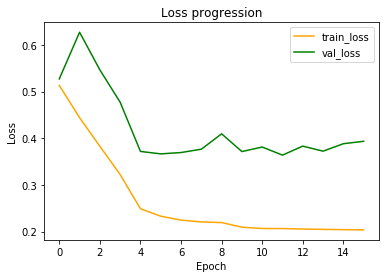

Starting Epoch 16
Will sample from train_loader
Train: [3900/1000 (10%)]	Loss: 0.204035	Elapsed time: 0:00:41.086311	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.00025271353661082685, 0.02285473421216011, 93.61299133300781)
Train: [10200/1000 (20%)]	Loss: 0.204115	Elapsed time: 0:01:23.281575	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0007130508311092854, 0.02285470813512802, 93.61288452148438)
Train: [19200/1000 (30%)]	Loss: 0.203030	Elapsed time: 0:02:04.932316	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.00033168462687171996, 0.022854894399642944, 93.6136474609375)
Train: [25600/1000 (40%)]	Loss: 0.202293	Elapsed time: 0:02:47.870117	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0007616282091476023, 0.022854991257190704, 93.61

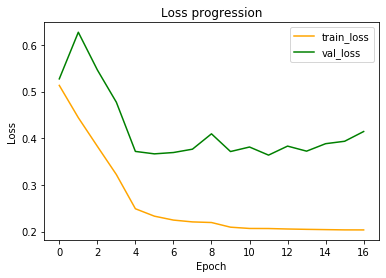

Starting Epoch 17
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.204792	Elapsed time: 0:00:42.172290	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0001543344696983695, 0.022855665534734726, 93.61680603027344)
Train: [9000/1000 (20%)]	Loss: 0.204917	Elapsed time: 0:01:24.565973	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.002)	FCWeights (Diff, Avg, Total): (0.0006975301657803357, 0.022855600342154503, 93.61653900146484)
Train: [14100/1000 (30%)]	Loss: 0.202867	Elapsed time: 0:02:05.093066	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.001)	FCWeights (Diff, Avg, Total): (0.00037433119723573327, 0.02285592630505562, 93.61787414550781)
Train: [25600/1000 (40%)]	Loss: 0.203833	Elapsed time: 0:02:47.039976	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.001)	FCWeights (Diff, Avg, Total): (0.0009653092129155993, 0.022856004536151886, 93.61

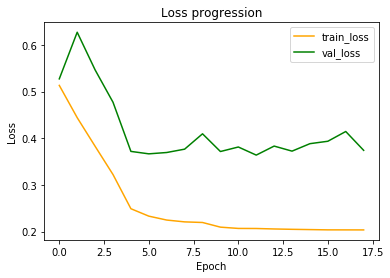

Starting Epoch 18
Will sample from train_loader
Train: [4100/1000 (10%)]	Loss: 0.201895	Elapsed time: 0:00:41.547101	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.199, 0.002)	FCWeights (Diff, Avg, Total): (0.0007516827317886055, 0.0228569358587265, 93.62200927734375)
Train: [12800/1000 (20%)]	Loss: 0.203643	Elapsed time: 0:01:23.118110	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.2, 0.001)	FCWeights (Diff, Avg, Total): (0.0014473216142505407, 0.02285689301788807, 93.62183380126953)
Train: [12600/1000 (30%)]	Loss: 0.202263	Elapsed time: 0:02:04.494430	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.2, 0.001)	FCWeights (Diff, Avg, Total): (0.0005606494378298521, 0.02285689301788807, 93.62183380126953)
Train: [25600/1000 (40%)]	Loss: 0.204808	Elapsed time: 0:02:46.873340	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (7.461561472155154e-05, 0.022856999188661575, 93.622268676

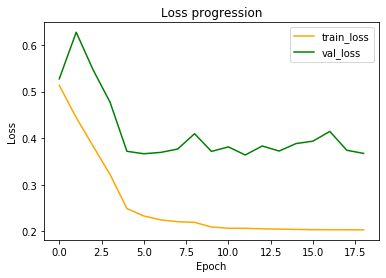

Starting Epoch 19
Will sample from train_loader
Train: [4400/1000 (10%)]	Loss: 0.203384	Elapsed time: 0:00:42.387435	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.001)	FCWeights (Diff, Avg, Total): (5.8161880588158965e-05, 0.022857578471302986, 93.62464141845703)
Train: [12800/1000 (20%)]	Loss: 0.205017	Elapsed time: 0:01:24.209702	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.202, 0.001)	FCWeights (Diff, Avg, Total): (8.758744661463425e-05, 0.022857598960399628, 93.62472534179688)
Train: [12300/1000 (30%)]	Loss: 0.202858	Elapsed time: 0:02:06.265374	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (1.3500695786206052e-05, 0.022857584059238434, 93.62466430664062)
Train: [25600/1000 (40%)]	Loss: 0.204257	Elapsed time: 0:02:49.120029	EmbeddingCosineSimilarityAndDistanceLossMetric (sim-, dist-): (0.201, 0.002)	FCWeights (Diff, Avg, Total): (0.0001405581133440137, 0.02285757288336754, 93.

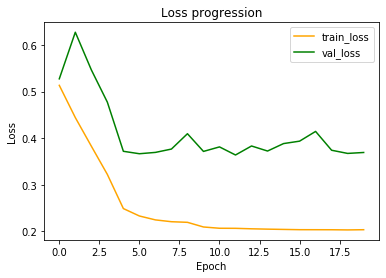

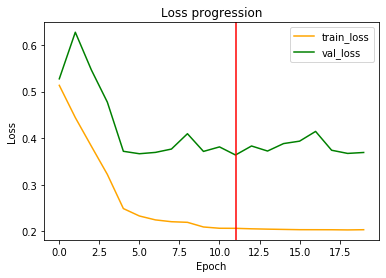

In [3]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = [EmbeddingCosineSimilarityAndDistanceLossMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

## Test trained model

### Load model

In [2]:
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_sim_length_2\training_state_11.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\soft_multisiamese_sim_length_2\training_state_11.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): 

### Load test set

In [3]:
test_path = r'C:\Users\root\Data\Angiographie'
test_set = get_test_set(test_path)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Compute distance and similarity matrices for each video

Batch 1/56 (AA-4 LCA_30LAO25CAU) with 103 sequences


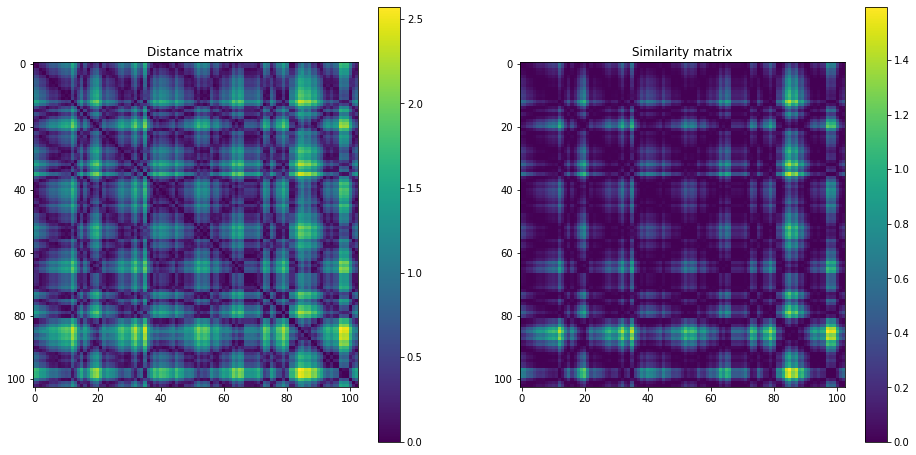

Batch 2/56 (AA-4 LCA_30RAO) with 108 sequences


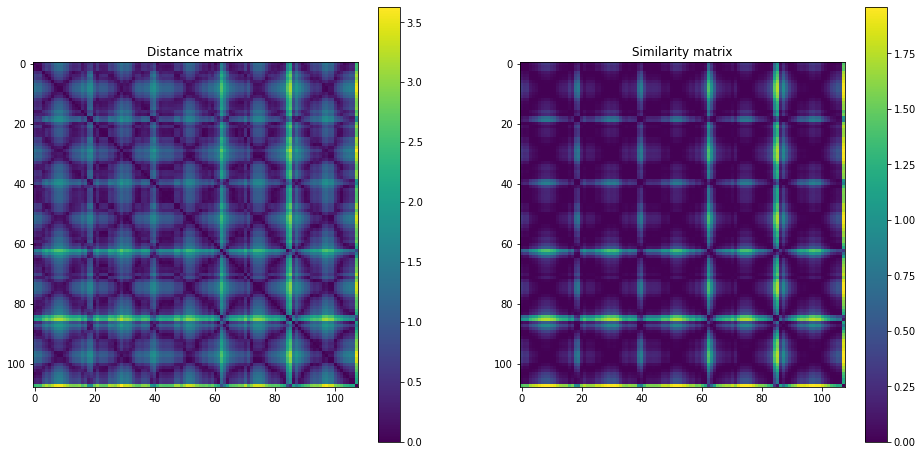

Batch 3/56 (AA-4 LCA_30RAO25CAU) with 102 sequences


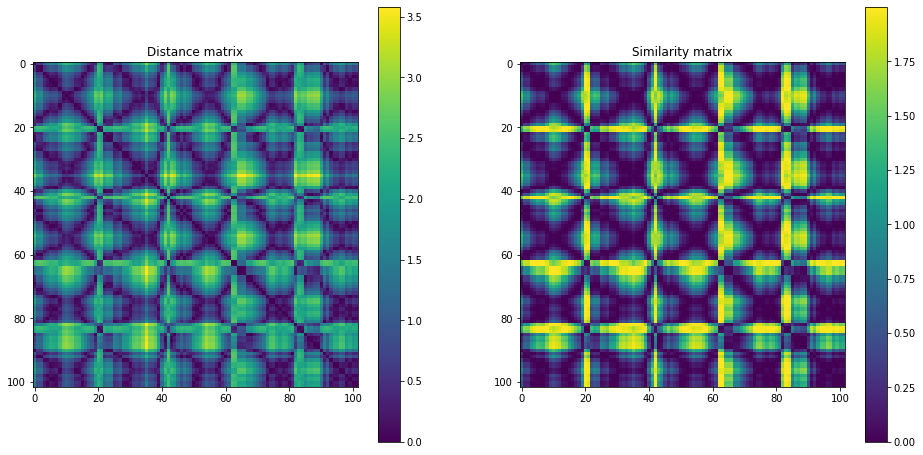

Batch 4/56 (AA-4 LCA_AP) with 76 sequences


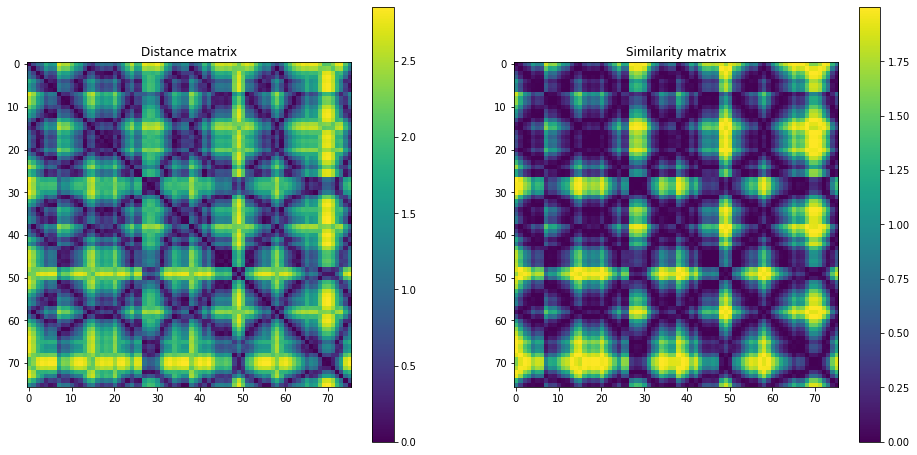

Batch 5/56 (AA-4 LCA_LAT) with 77 sequences


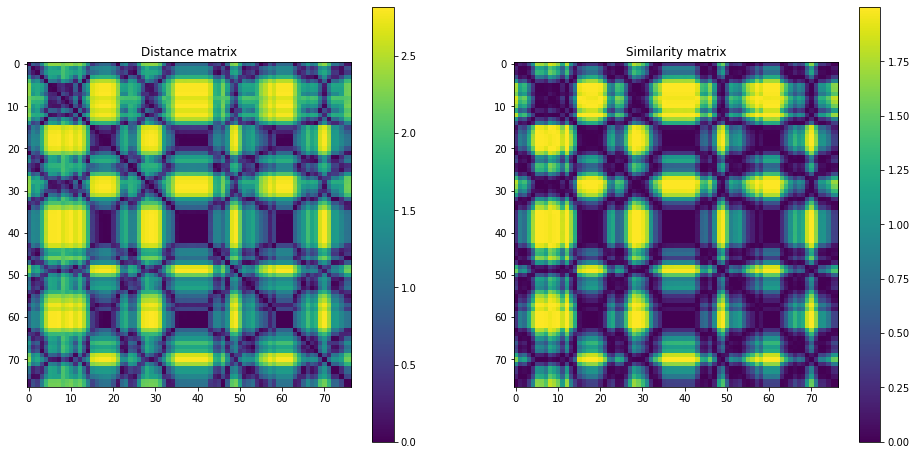

Batch 6/56 (AA-4 RCA_AP) with 119 sequences


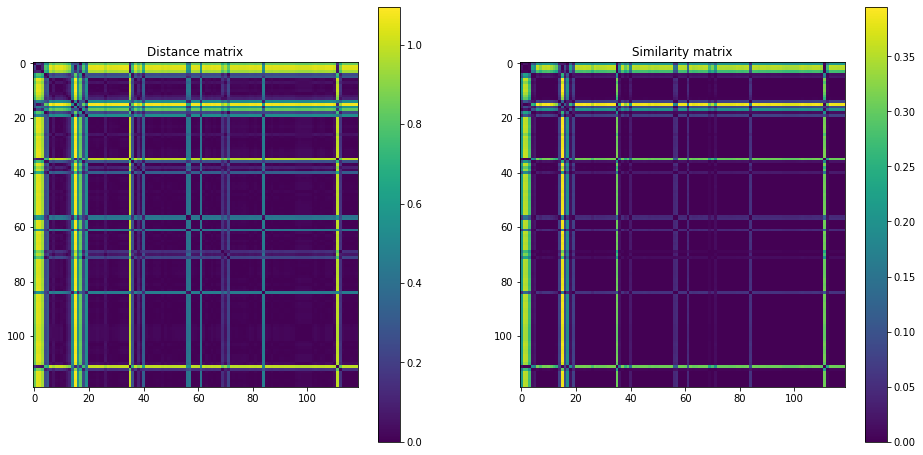

Batch 7/56 (AA-4 RCA_LAT) with 111 sequences


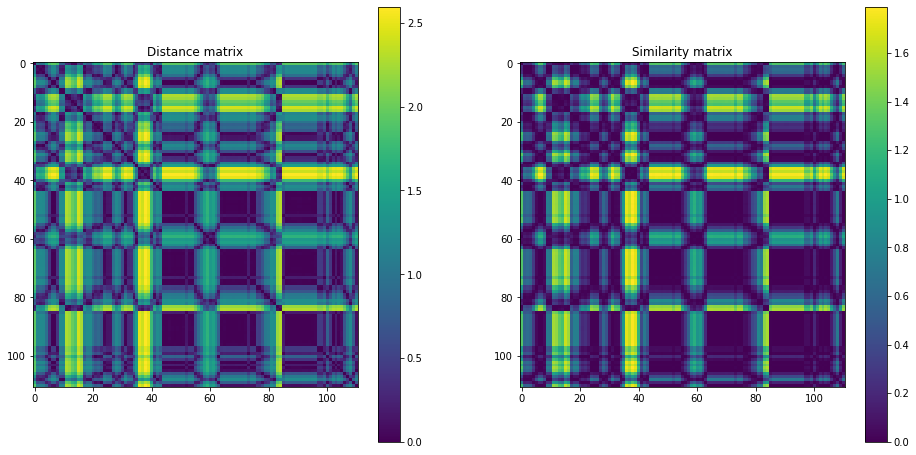

Batch 8/56 (ABL-5 LCA_30LAO25CRA) with 73 sequences


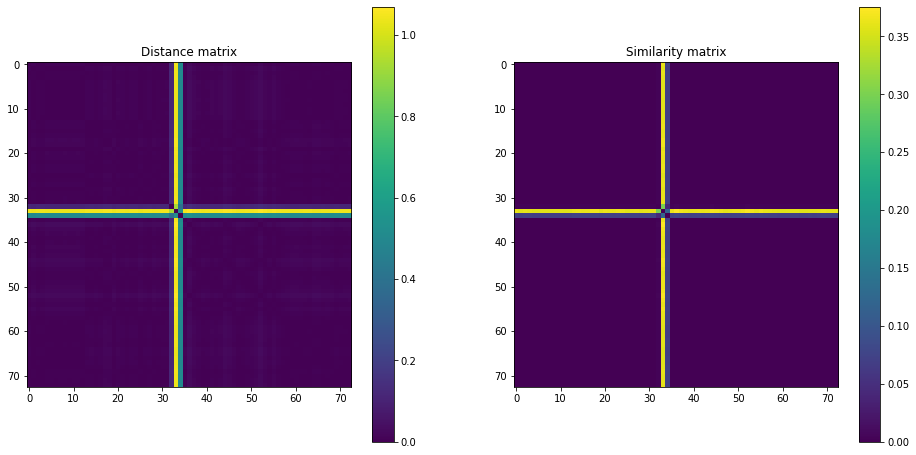

Batch 9/56 (ABL-5 LCA_30RAO) with 76 sequences


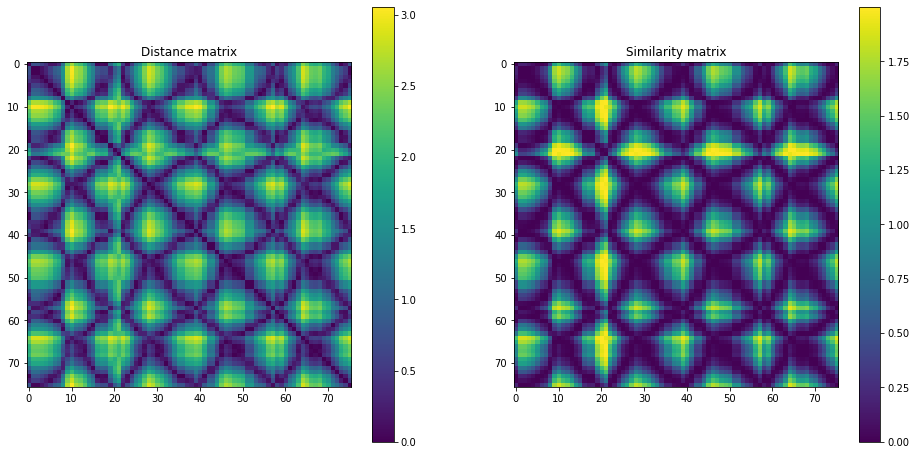

Batch 10/56 (ABL-5 LCA_AP) with 83 sequences


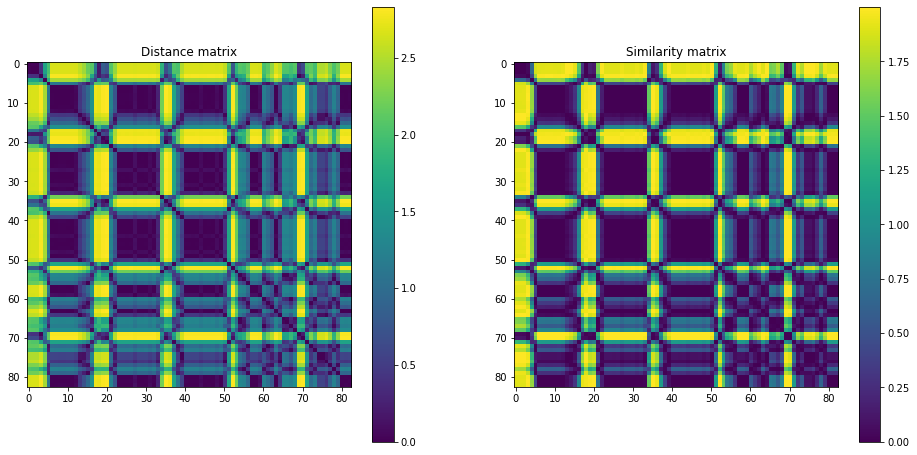

Batch 11/56 (ABL-5 LCA_LAT) with 83 sequences


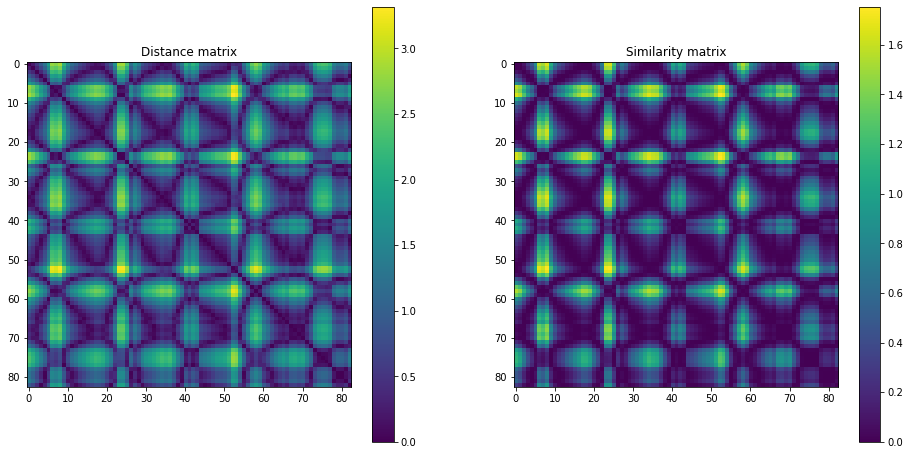

Batch 12/56 (ABL-5 RCA_AP) with 37 sequences


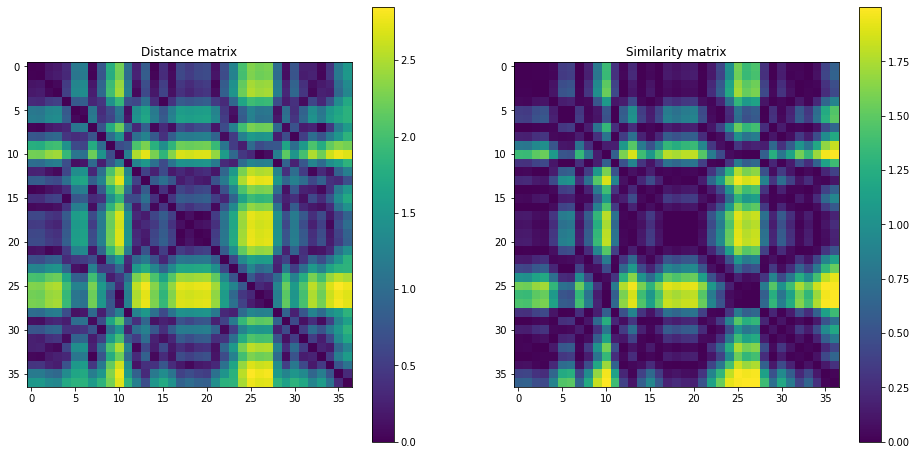

Batch 13/56 (ABL-5 RCA_LAT) with 37 sequences


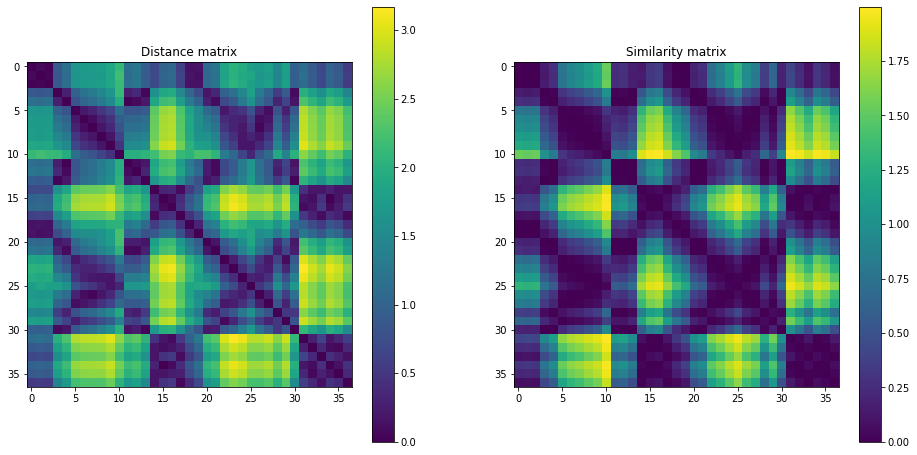

Batch 14/56 (AC-1 LCA_40RA015CAU) with 46 sequences


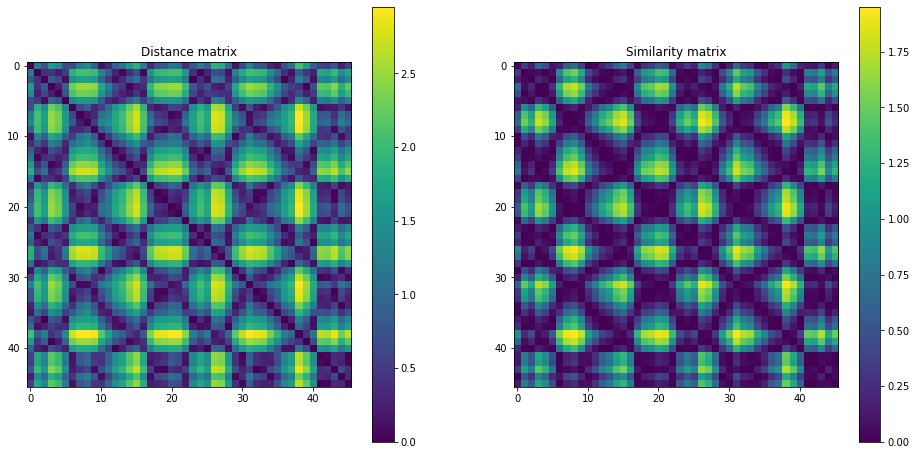

Batch 15/56 (AC-1 LCA_45LAO) with 42 sequences


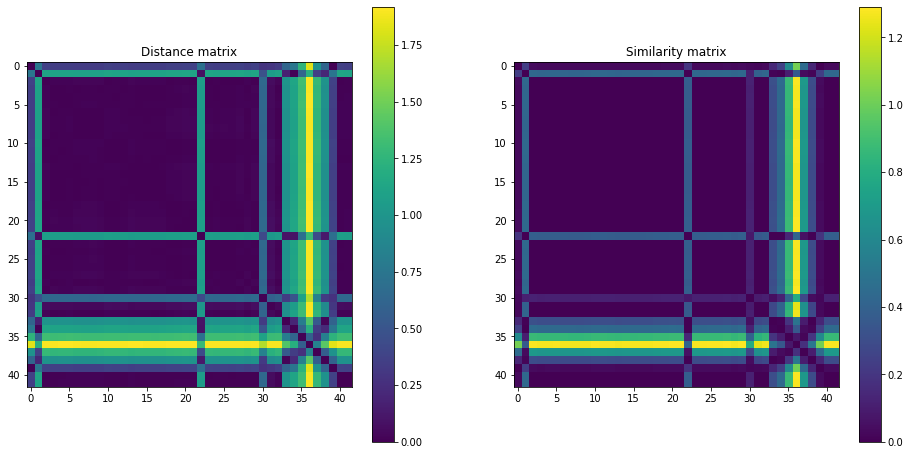

Batch 16/56 (AC-1 LCA_AP) with 47 sequences


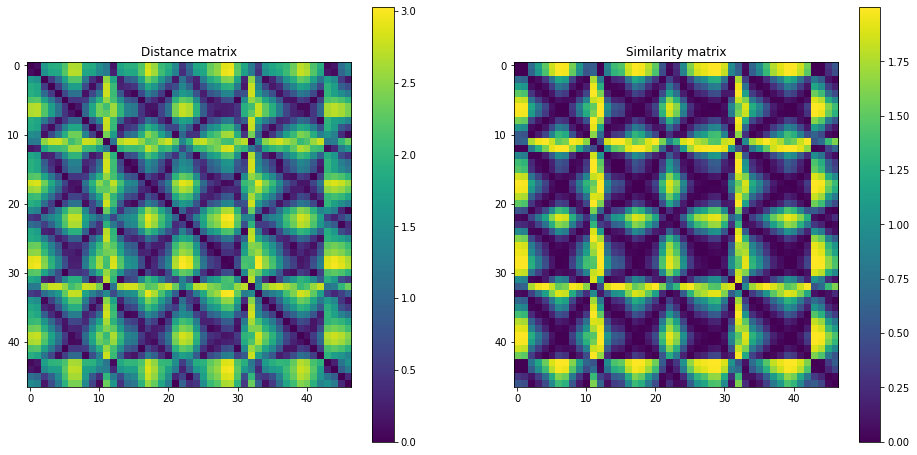

Batch 17/56 (AC-1 LCA_LAT) with 49 sequences


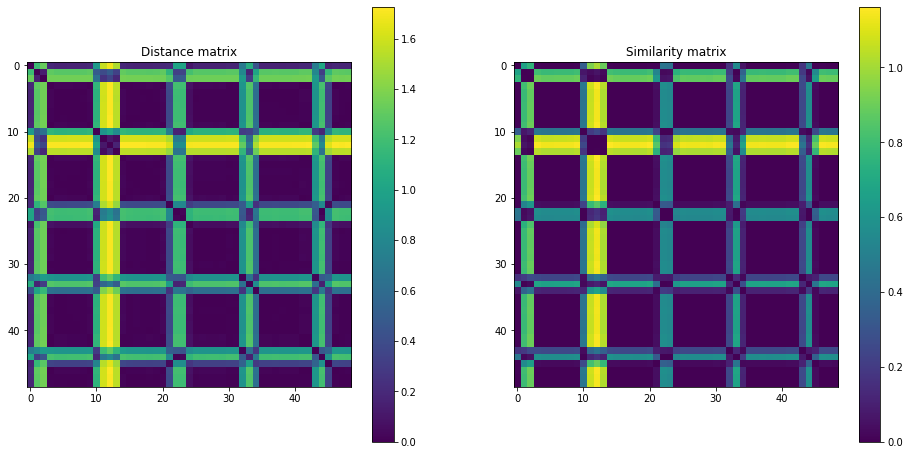

Batch 18/56 (AC-1 RCA_AP) with 52 sequences


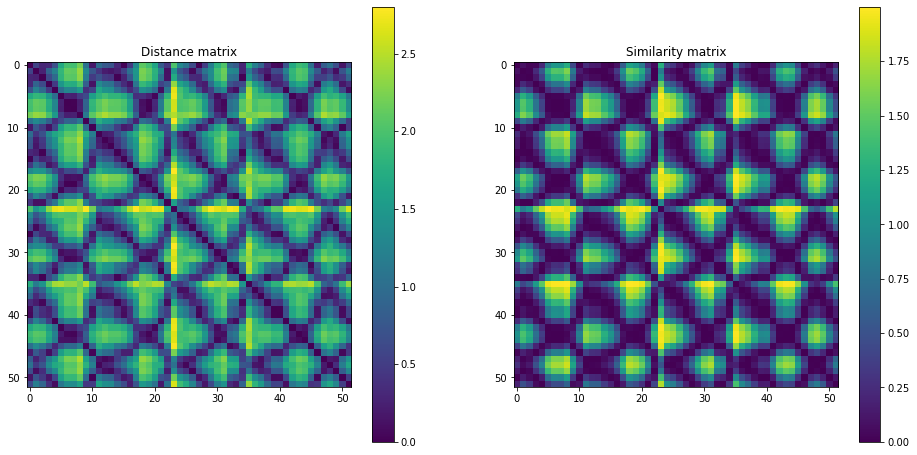

Batch 19/56 (AC-1 RCA_LAT) with 58 sequences


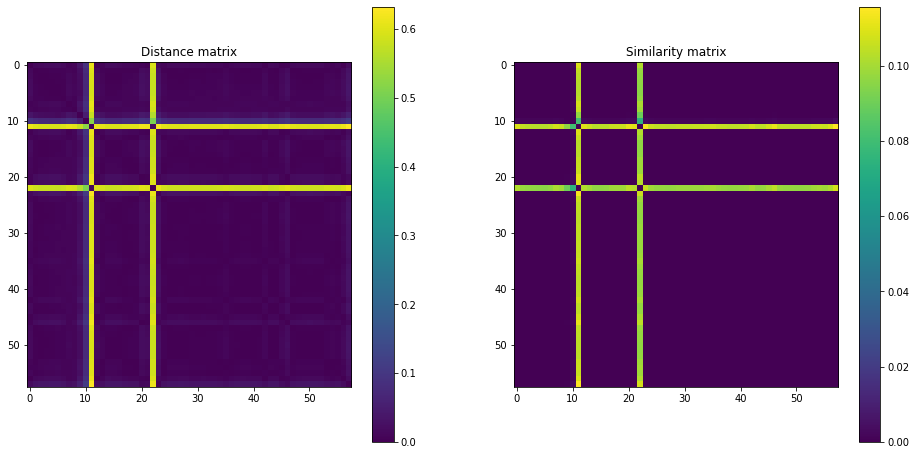

Batch 20/56 (ALR-2 LCA_30LAO25CRA) with 49 sequences


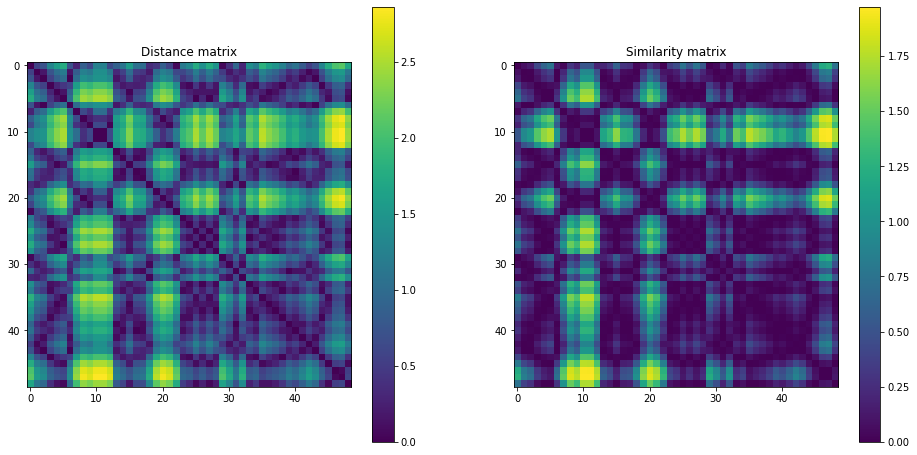

Batch 21/56 (ALR-2 LCA_30RAO) with 44 sequences


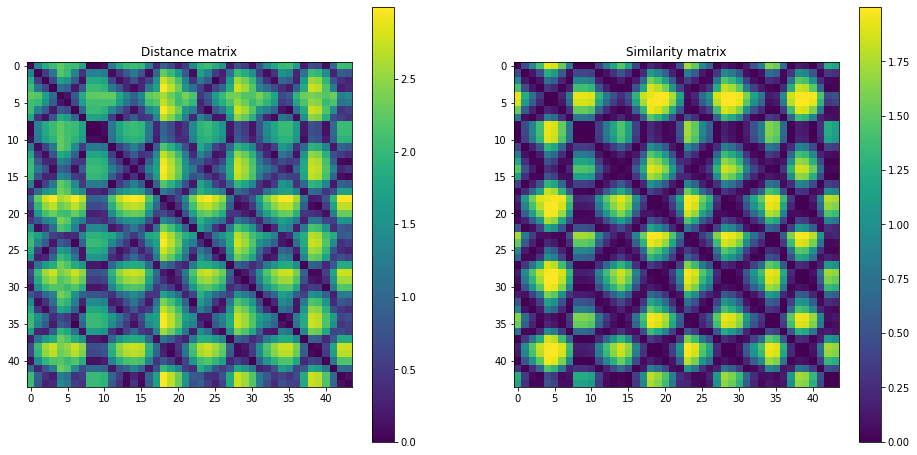

Batch 22/56 (ALR-2 LCA_AP) with 46 sequences


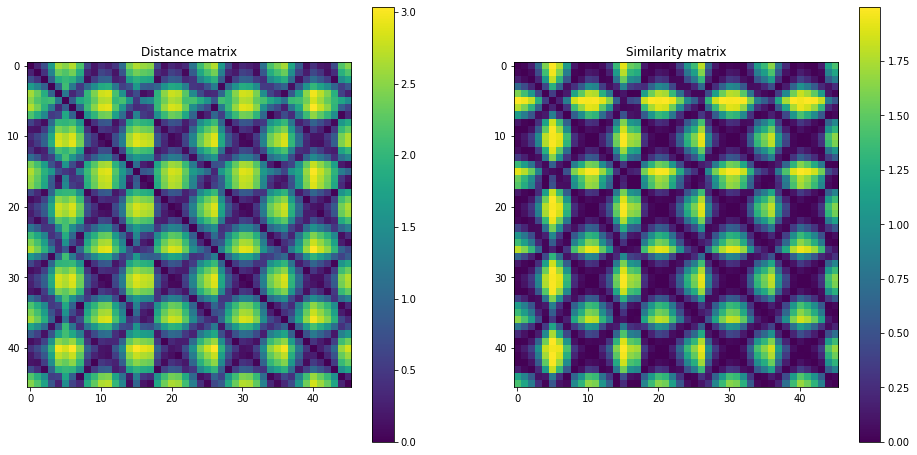

Batch 23/56 (ALR-2 LCA_LAT) with 47 sequences


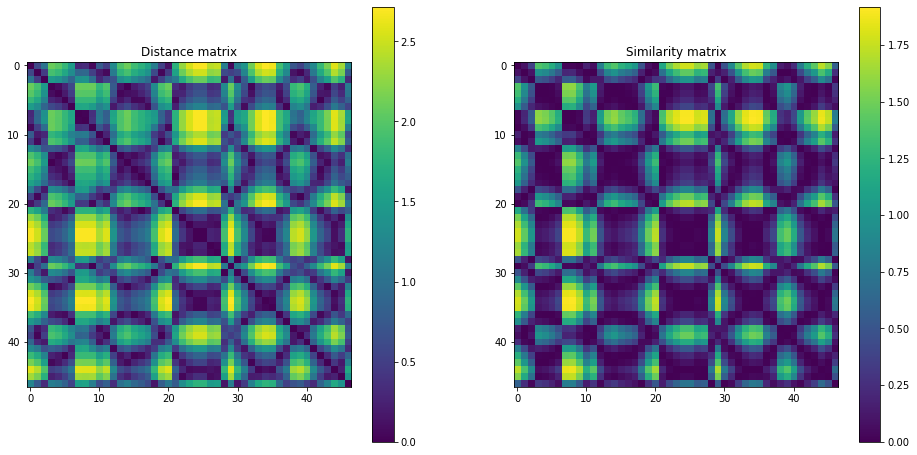

Batch 24/56 (ALR-2 RCA_AP) with 60 sequences


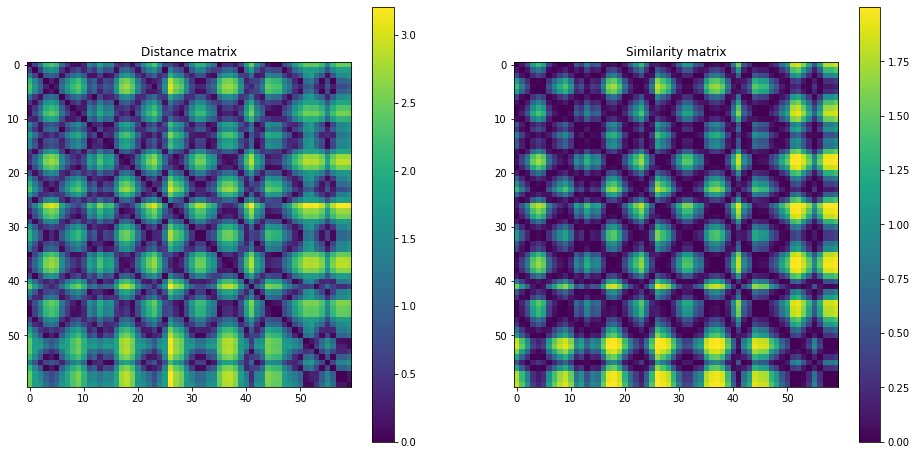

Batch 25/56 (JEL-10 LCA_30RA025CAU) with 51 sequences


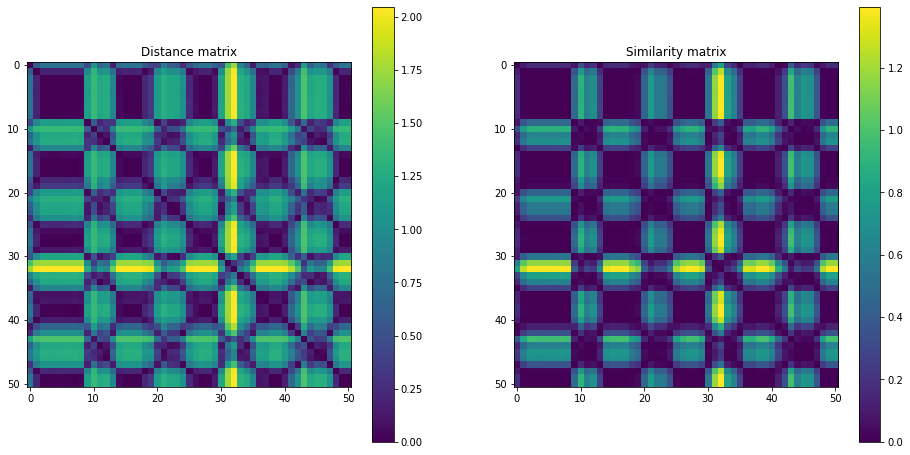

Batch 26/56 (JEL-10 LCA_30RAO) with 43 sequences


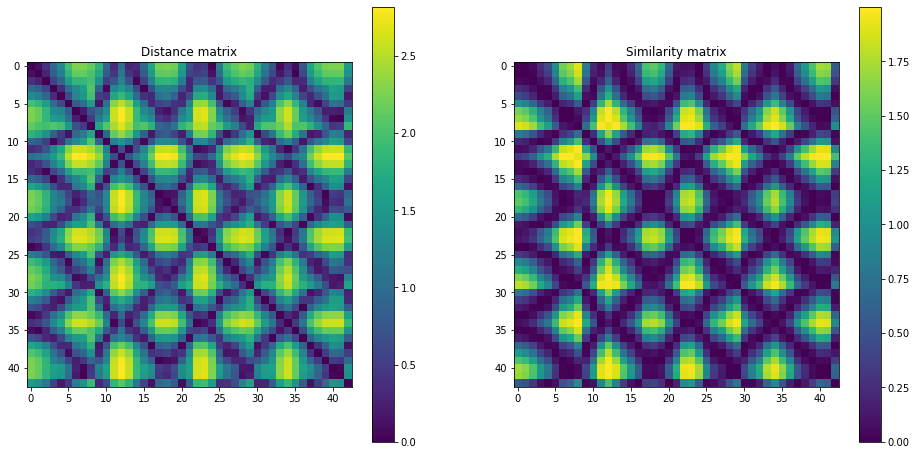

Batch 27/56 (JEL-10 LCA_AP) with 29 sequences


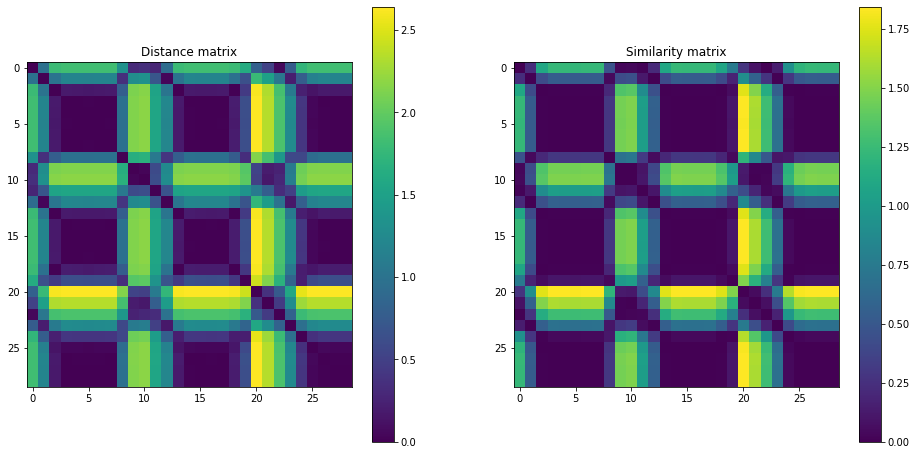

Batch 28/56 (JEL-10 LCA_LAT) with 68 sequences


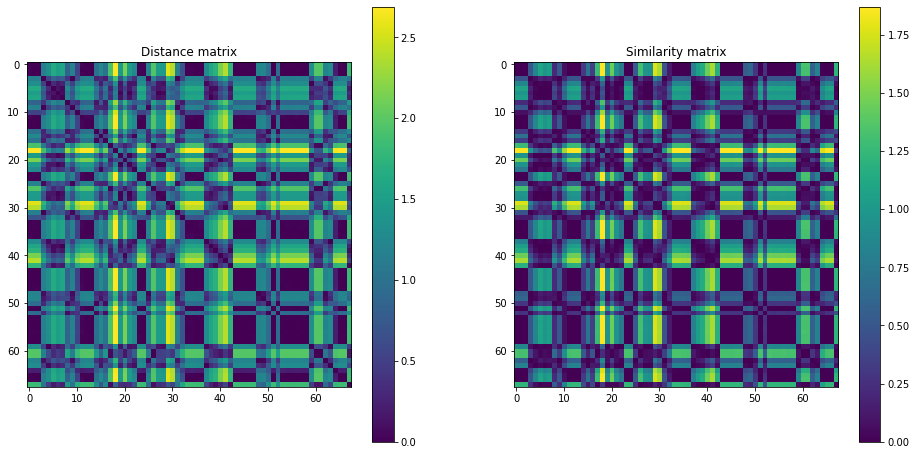

Batch 29/56 (JEL-10 RCA_AP) with 63 sequences


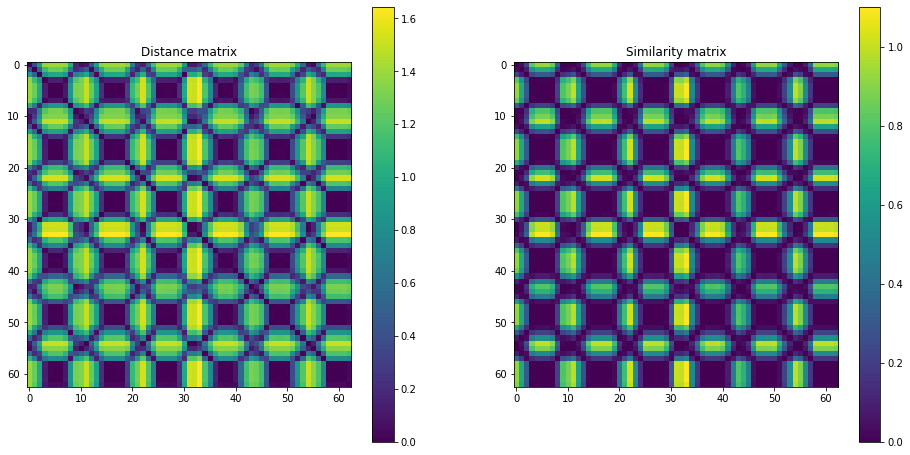

Batch 30/56 (JEL-10 RCA_LAT) with 42 sequences


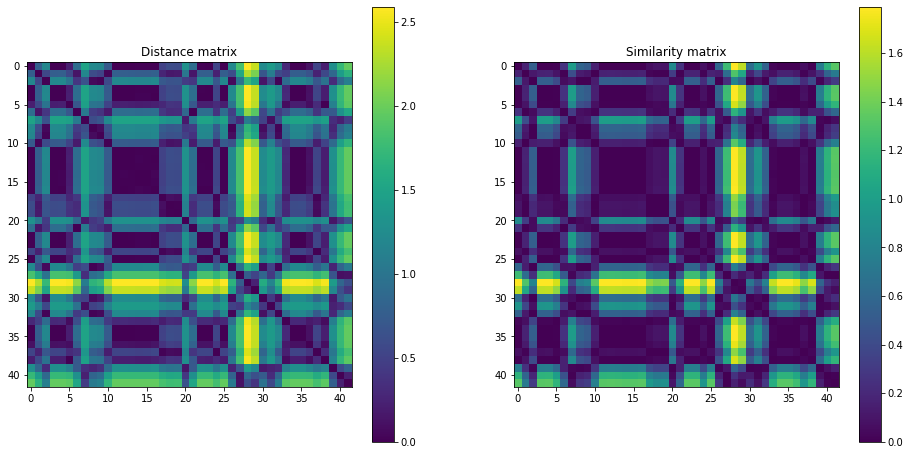

Batch 31/56 (KC-3 LCA_30RAO) with 82 sequences


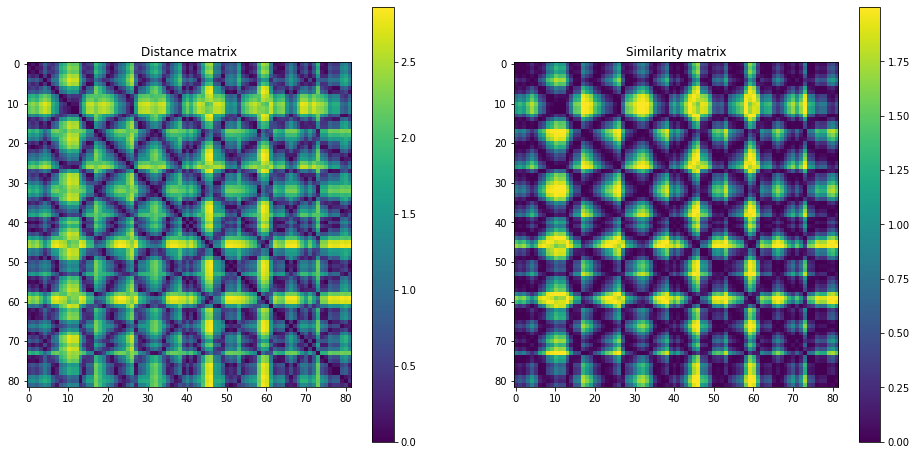

Batch 32/56 (KC-3 LCA_30RAO25CAU) with 97 sequences


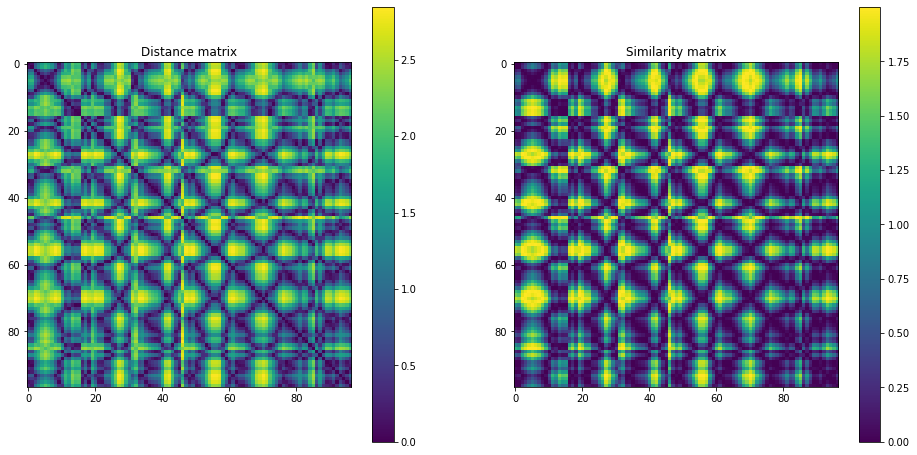

Batch 33/56 (KC-3 LCA_AP) with 80 sequences


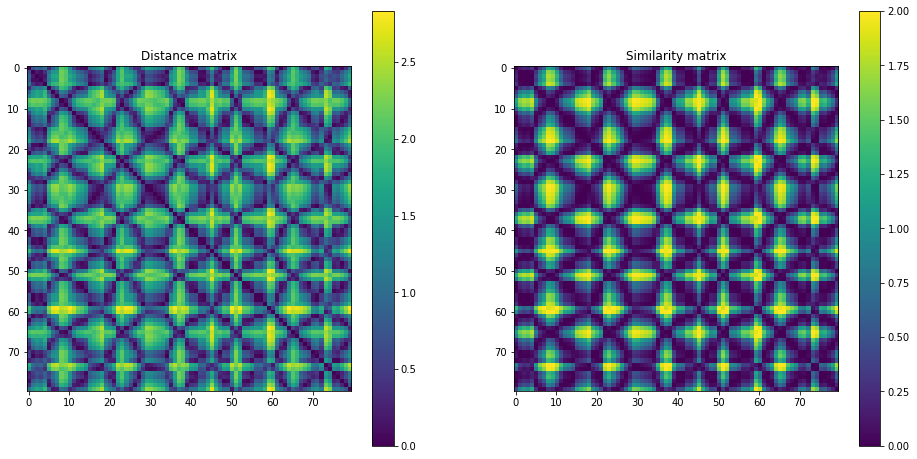

Batch 34/56 (KC-3 LCA_LAT) with 73 sequences


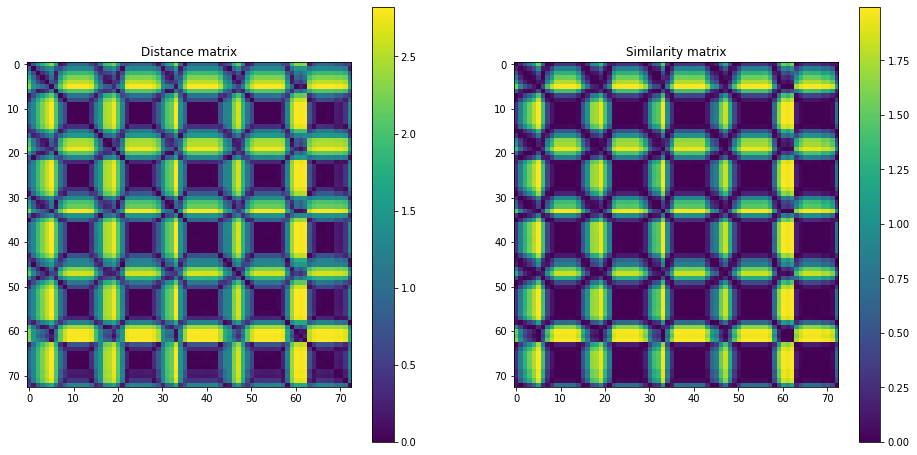

Batch 35/56 (KC-3 RCA_AP) with 92 sequences


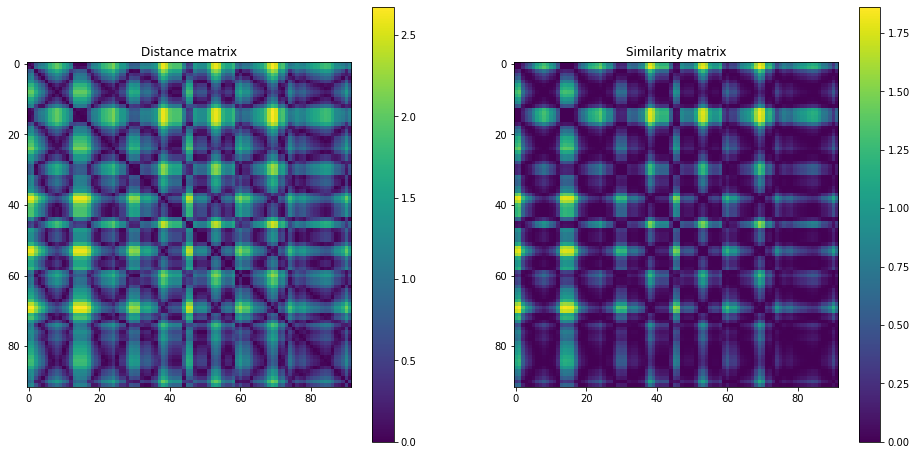

Batch 36/56 (KC-3 RCA_LAT) with 105 sequences


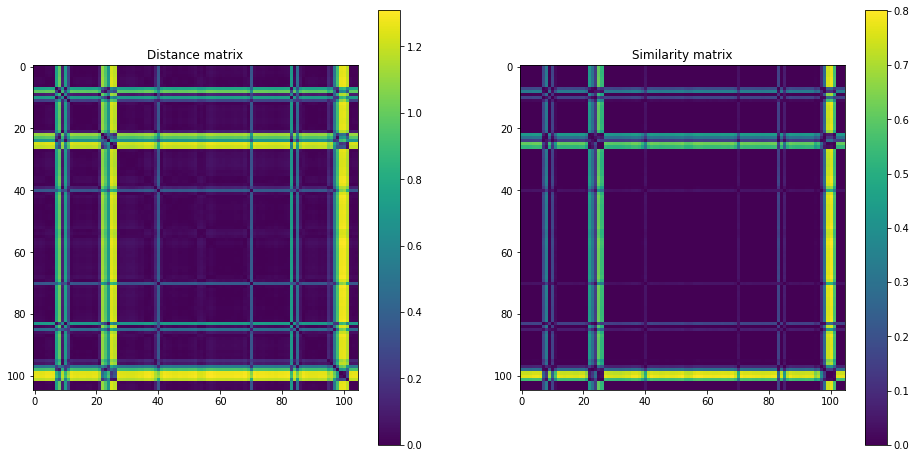

Batch 37/56 (KR-11 LCA_30LAO25CAU) with 37 sequences


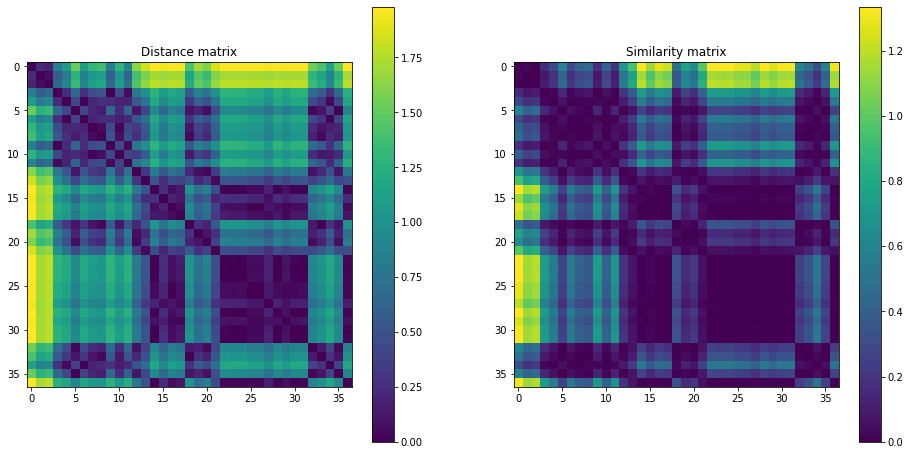

Batch 38/56 (KR-11 LCA_30LAO25CRA) with 40 sequences


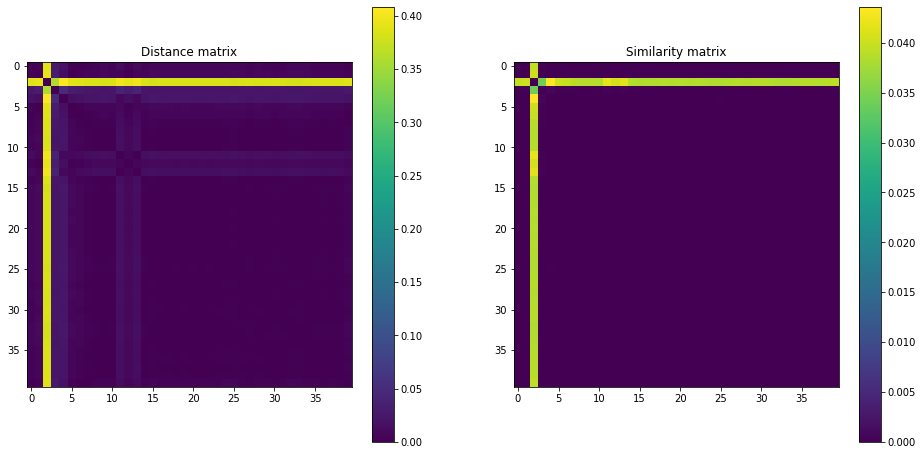

Batch 39/56 (KR-11 LCA_30RAO) with 39 sequences


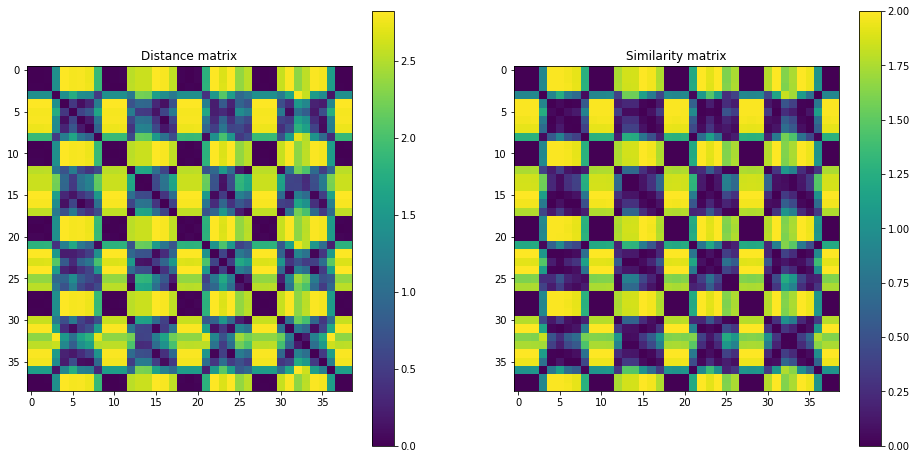

Batch 40/56 (KR-11 LCA_AP) with 48 sequences


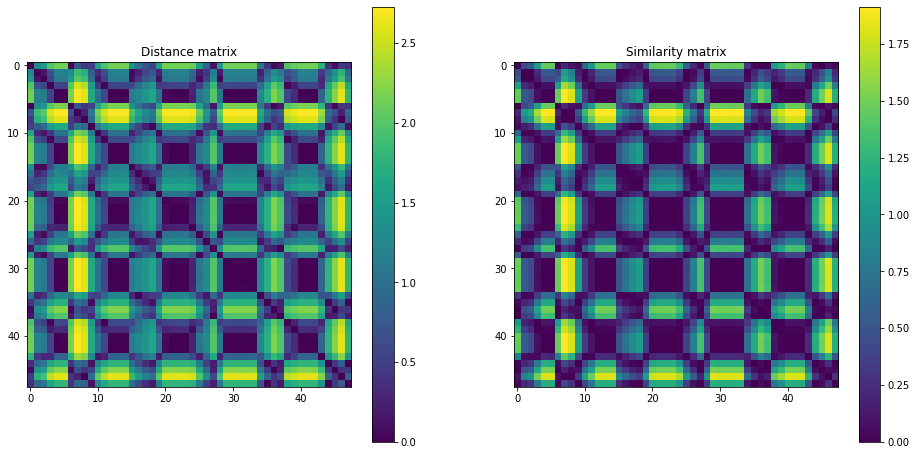

Batch 41/56 (KR-11 LCA_LAT) with 43 sequences


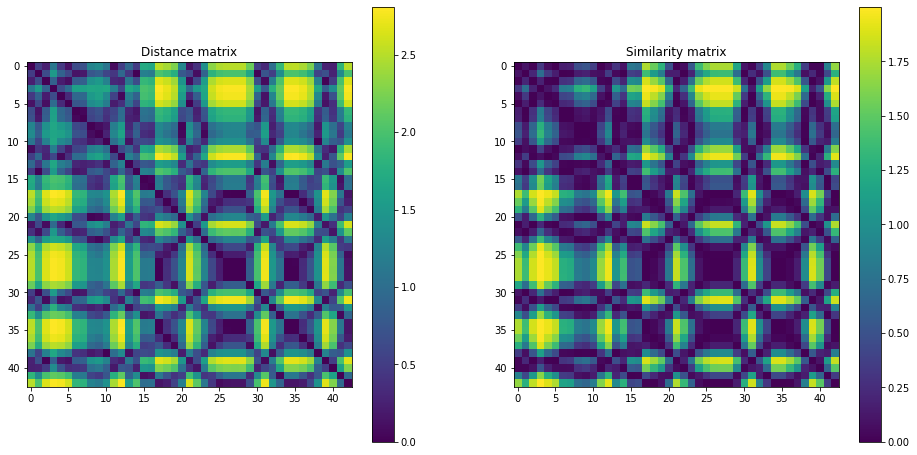

Batch 42/56 (KR-11 RCA_AP) with 61 sequences


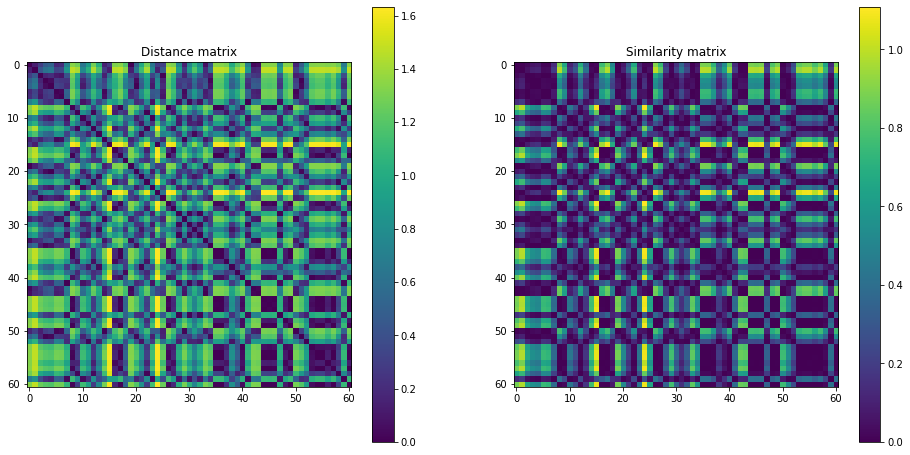

Batch 43/56 (KR-11 RCA_LAT) with 74 sequences


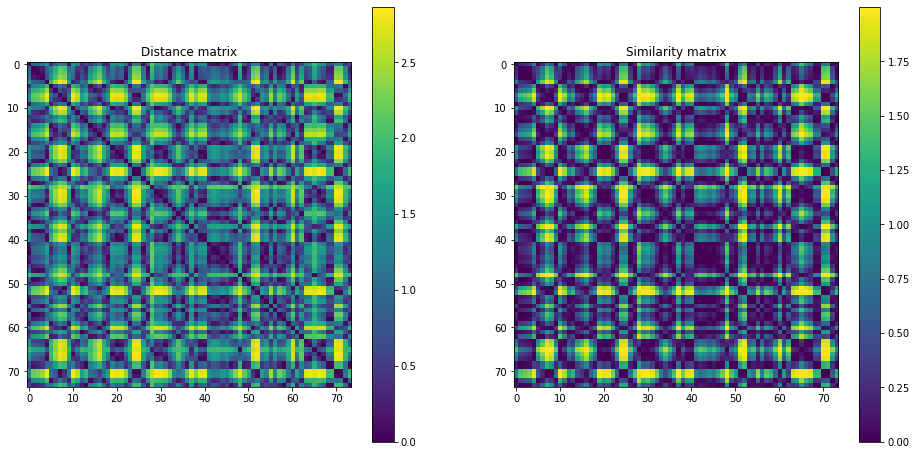

Batch 44/56 (MAL-8 LCA_AP) with 48 sequences


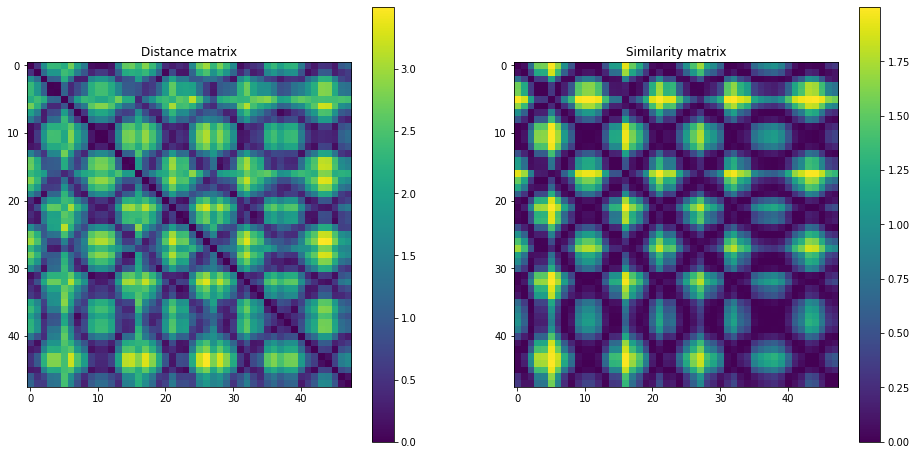

Batch 45/56 (MAL-8 LCA_LAT) with 45 sequences


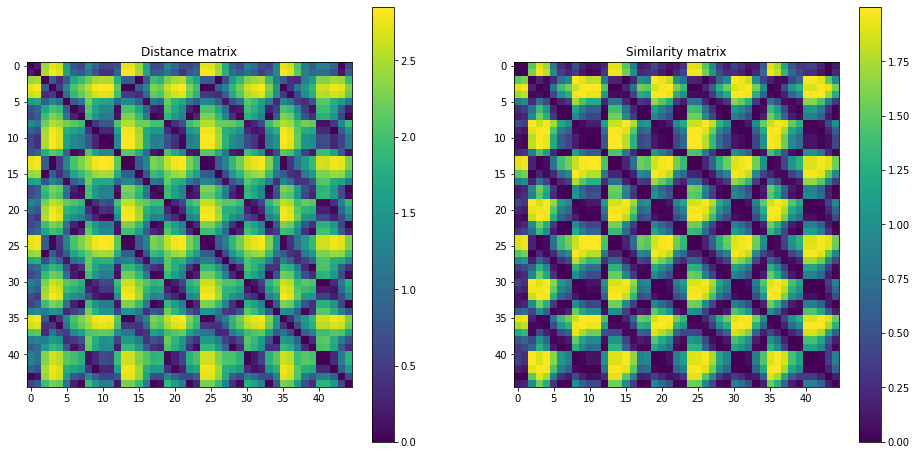

Batch 46/56 (MAL-8 RCA_AP) with 39 sequences


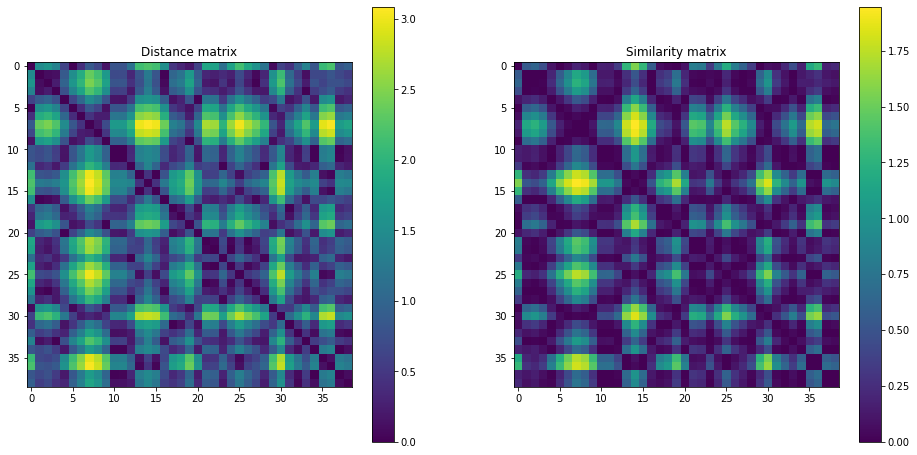

Batch 47/56 (MAL-8 RCA_LAT) with 39 sequences


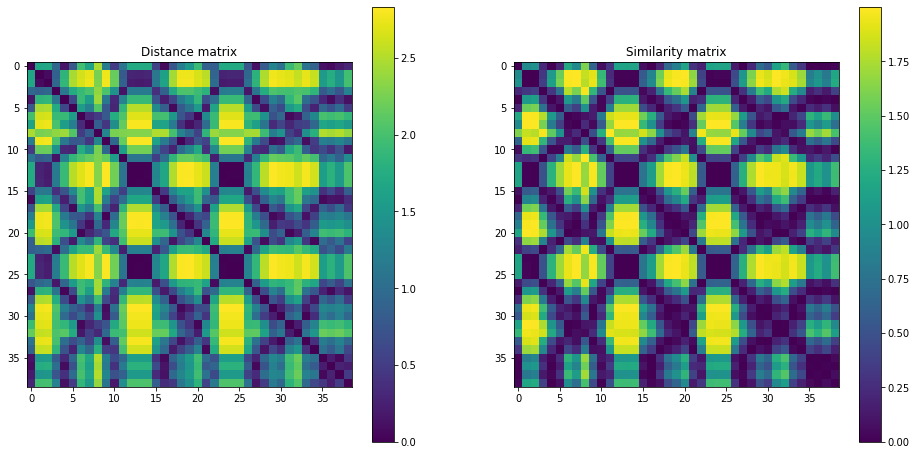

Batch 48/56 (MB-12 LCA_30LAO25CRA) with 50 sequences


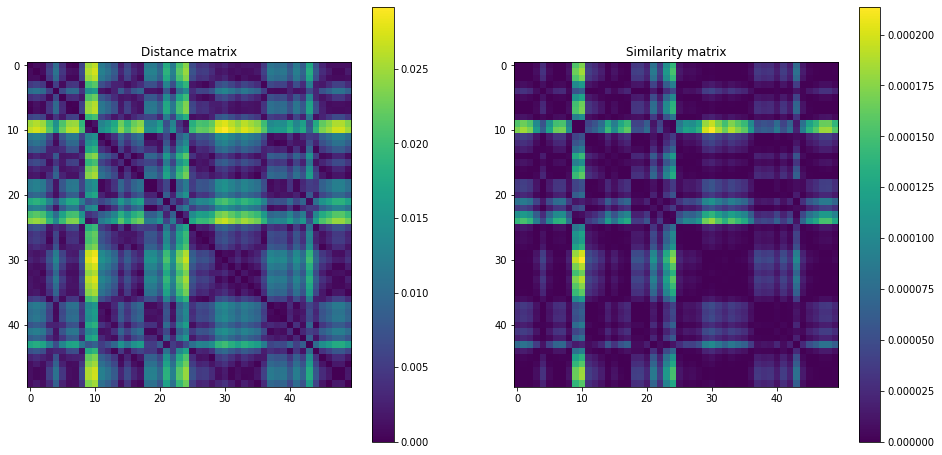

Batch 49/56 (MB-12 LCA_30RAO) with 53 sequences


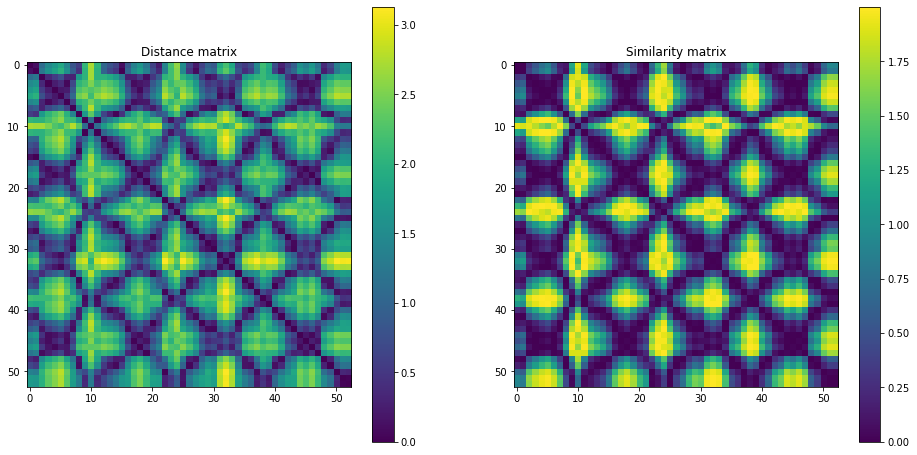

Batch 50/56 (MB-12 LCA_30RAO25CAU) with 49 sequences


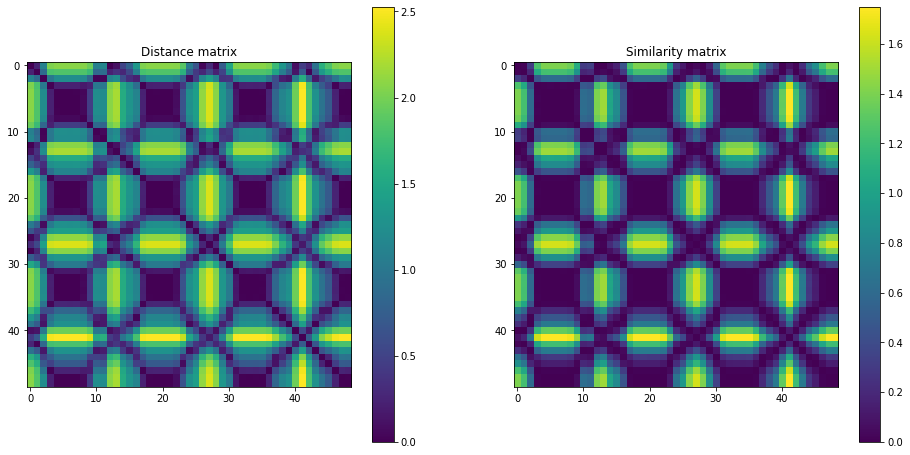

Batch 51/56 (MB-12 LCA_AP) with 49 sequences


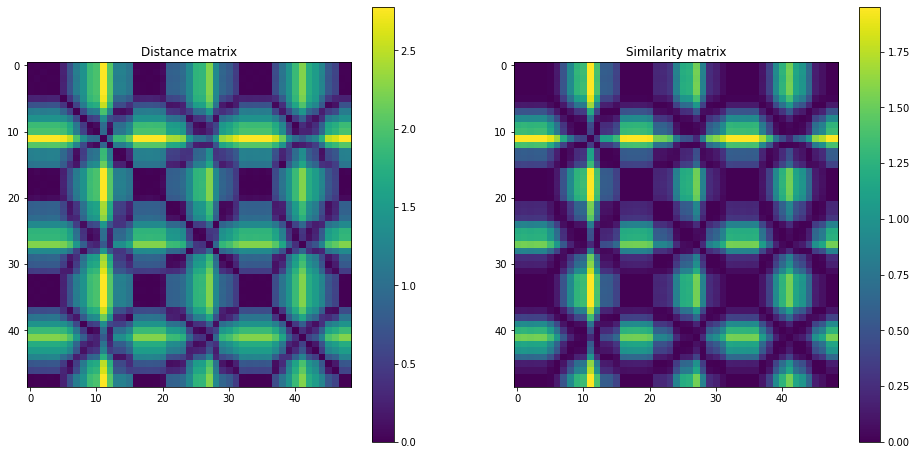

Batch 52/56 (MB-12 LCA_LAT) with 50 sequences


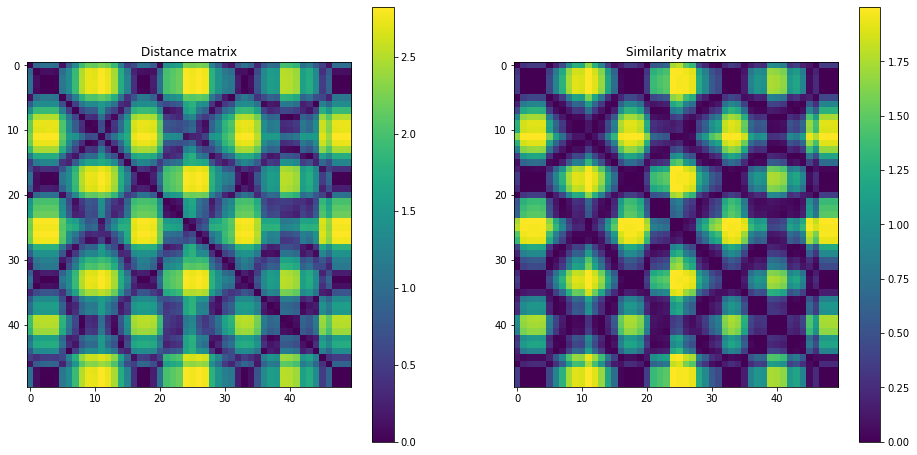

Batch 53/56 (MJY-9 RCA_AP) with 44 sequences


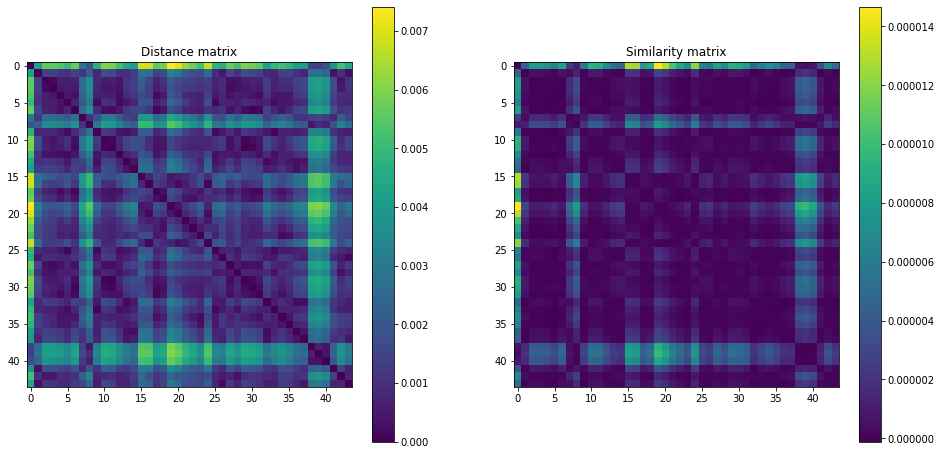

Batch 54/56 (MJY-9 RCA_LAT) with 50 sequences


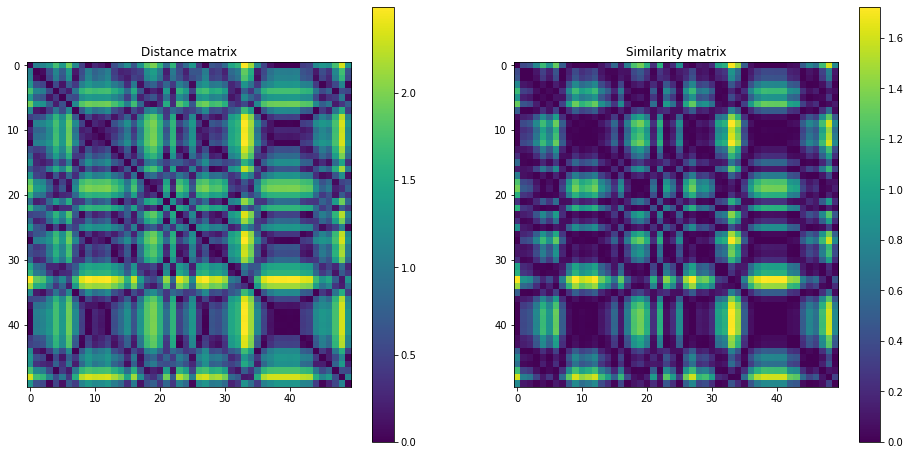

Batch 55/56 (SB-6 RCA_AP) with 41 sequences


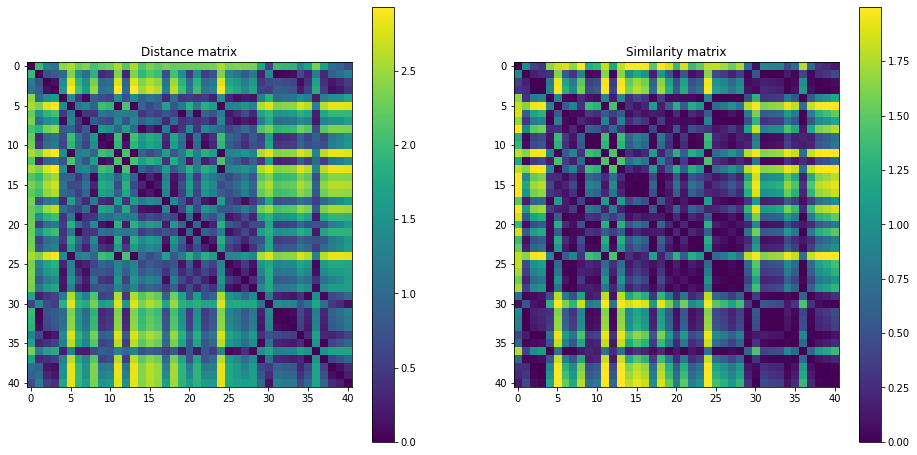

Batch 56/56 (SB-6 RCA_LAT) with 39 sequences


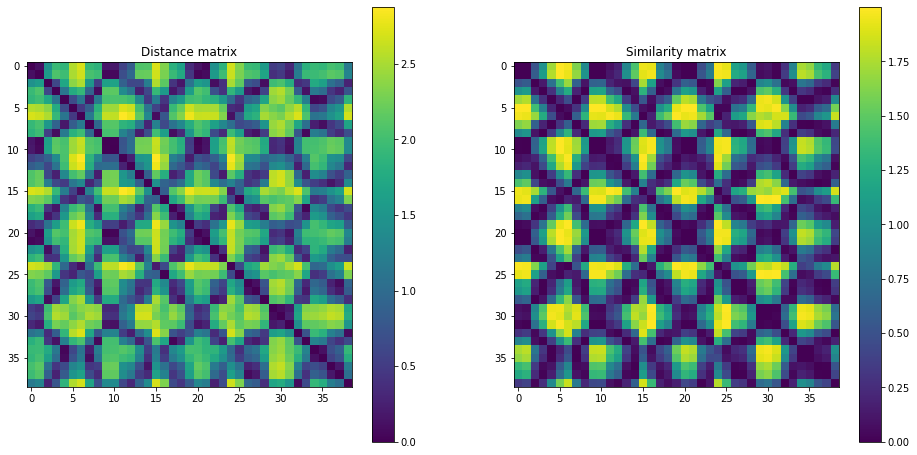

In [4]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()

### Compute distance and similarity matrices for video comparison

Combinations of AA-4
Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO


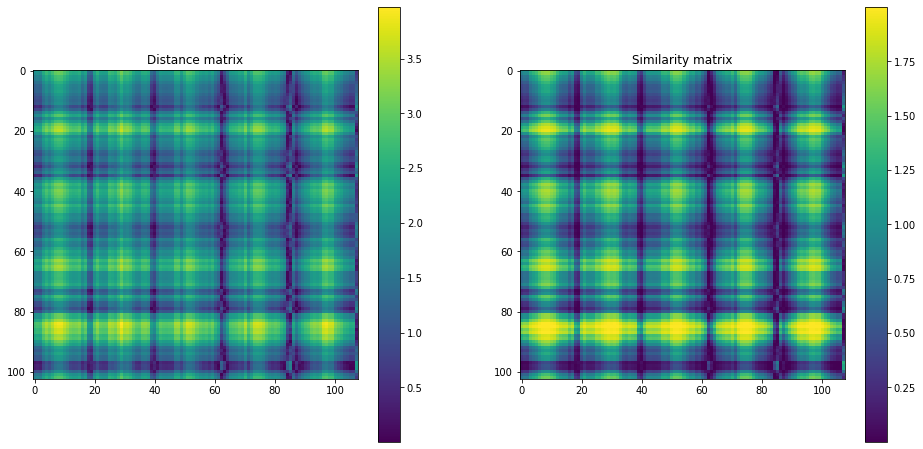

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_30RAO25CAU


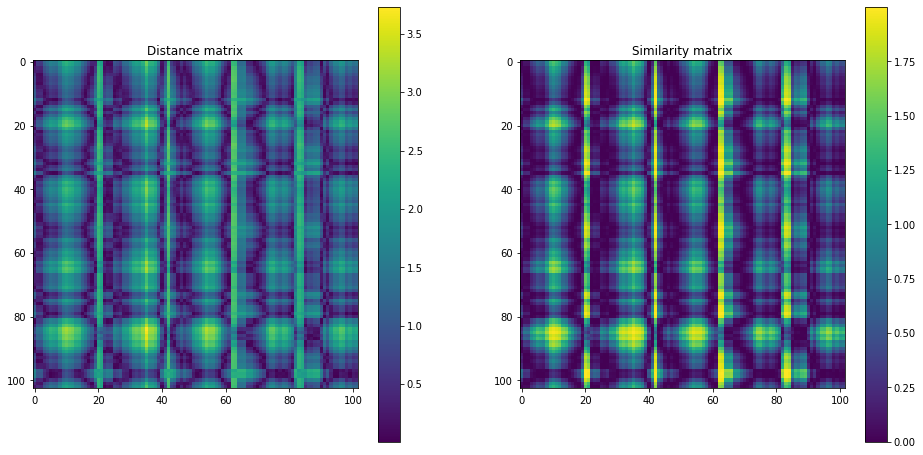

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_AP


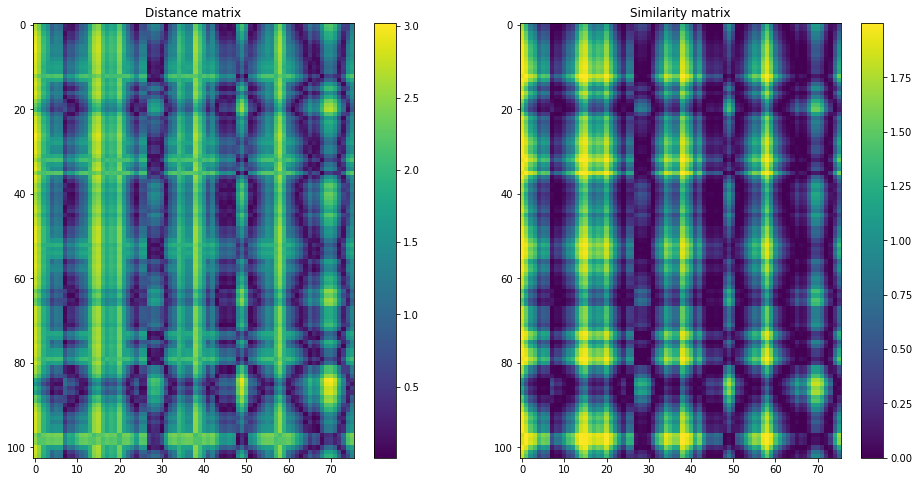

Comparison of AA-4 LCA_30LAO25CAU and AA-4 LCA_LAT


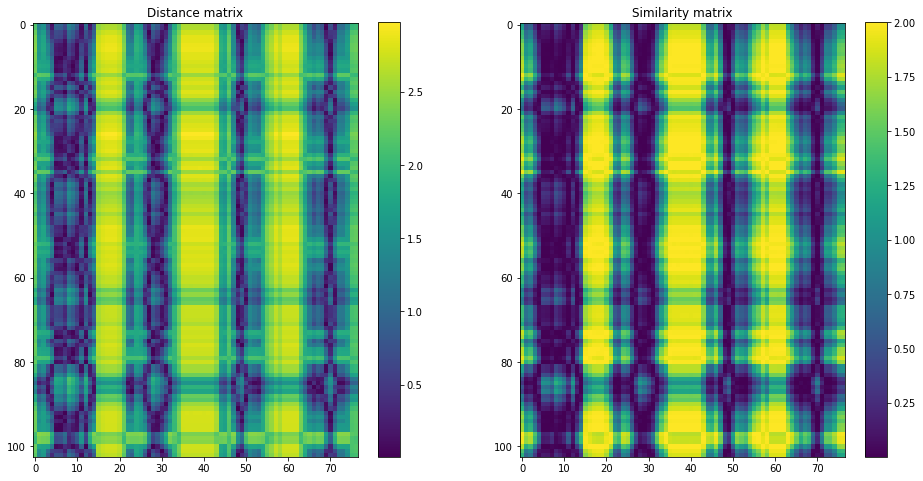

Comparison of AA-4 LCA_30LAO25CAU and AA-4 RCA_AP


KeyboardInterrupt: 

In [5]:
def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    try:
        all_embeddings
    except NameError:
        all_embeddings = []
        compute_embeddings = True
    else:
        compute_embeddings = False
    if compute_embeddings:
        print (f"Computing embeddings")
        names = []
        for batch_index, sequences in enumerate(test_loader):
            name = sequences[1][0]
            sequences = sequences[0]

            # sequences: (batch, video_frame, channel, width, height)
            embeddings = []
            print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
            embeddings = model(sequences[0])
            all_embeddings.append(embeddings)
            names.append(name)
    
    distance_matrices = {}
    similarity_matrices = {}
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        distance_matrices[names[i]] = {}
        similarity_matrices[names[i]] = {}
        current_name = name_i
        for j in range(i+1, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])
                distance_matrices[names[i]][names[j]] = distance_matrix
                similarity_matrices[names[i]][names[j]] = similarity_matrix
                
                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()

### Compare similar frames

In [13]:
import cv2
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    print(name_a, sequences_a.shape)
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        print(name_b, sequences_b.shape)
        if name_b in distance_matrices[name_a]:
            distance_matrix = distance_matrices[name_a][name_b]
            video_frames = []
            for frame_a in range(len(distance_matrix)):
                frame_b = np.argmax(distance_matrix[frame_a])
                img_frame_a = sequences_a[frame_a][-1]
                img_frame_b = sequences_b[frame_b][-1]
                video_frame = np.concatenate((img_frame_a, img_frame_b), axis=-1)
                video_frame = np.uint8(video_frame * 255)
#                 video_frame = video_frame[np.newaxis, :, :]
#                 video_frame = np.repeat(video_frame, 3, axis=0)
                video_frames.append(video_frame)
                
#                 figure(figsize=(16,8))
#                 plt.subplot(1, 2, 1)
#                 plt.imshow(img_frame_a)
#                 plt.title(f"Frame {frame_a}")
#                 plt.subplot(1, 2, 2)
#                 plt.imshow(img_frame_b)
#                 plt.title(f"Frame {frame_b}")
#                 plt.show()
                
            vid = cv2.VideoWriter(save_path + f'/{name_a} with {name_b}.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, video_frame.shape)
            for i in range(len(video_frames)):
                vid.write(video_frames[i])
            vid.release()
                
                
# for video_a in distance_matrices:
#     video_pairs = distance_matrices[video_a]
#     print(video_a, len(video_pairs))
#     for video_b in video_pairs:
#         distance_matrix = video_pairs[video_b]
#         print("-", video_b, distance_matrix.shape)
#         for frame_a in distance_matrix:
#             plt.plot(frame_a)
#             plt.show()

AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30LAO25CAU torch.Size([103, 3, 224, 224])
AA-4 LCA_30RAO torch.Size([108, 3, 224, 224])
AA-4 LCA_30RAO25CAU torch.Size([102, 3, 224, 224])
AA-4 LCA_AP torch.Size([76, 3, 224, 224])
AA-4 LCA_LAT torch.Size([77, 3, 224, 224])
AA-4 RCA_AP torch.Size([119, 3, 224, 224])
AA-4 RCA_LAT torch.Size([111, 3, 224, 224])
ABL-5 LCA_30LAO25CRA torch.Size([73, 3, 224, 224])
ABL-5 LCA_30RAO torch.Size([76, 3, 224, 224])
ABL-5 LCA_AP torch.Size([83, 3, 224, 224])
ABL-5 LCA_LAT torch.Size([83, 3, 224, 224])
ABL-5 RCA_AP torch.Size([37, 3, 224, 224])
ABL-5 RCA_LAT torch.Size([37, 3, 224, 224])
AC-1 LCA_40RA015CAU torch.Size([46, 3, 224, 224])
AC-1 LCA_45LAO torch.Size([42, 3, 224, 224])
AC-1 LCA_AP torch.Size([47, 3, 224, 224])
AC-1 LCA_LAT torch.Size([49, 3, 224, 224])
AC-1 RCA_AP torch.Size([52, 3, 224, 224])
AC-1 RCA_LAT torch.Size([58, 3, 224, 224])
ALR-2 LCA_30LAO25CRA torch.Size([49, 3, 224, 224])
ALR-2 LCA_30RAO torch.Size([44, 3, 224, 22

AC-1 RCA_LAT torch.Size([58, 3, 224, 224])
ALR-2 LCA_30LAO25CRA torch.Size([49, 3, 224, 224])
ALR-2 LCA_30RAO torch.Size([44, 3, 224, 224])
ALR-2 LCA_AP torch.Size([46, 3, 224, 224])
ALR-2 LCA_LAT torch.Size([47, 3, 224, 224])
ALR-2 RCA_AP torch.Size([60, 3, 224, 224])
JEL-10 LCA_30RA025CAU torch.Size([51, 3, 224, 224])
JEL-10 LCA_30RAO torch.Size([43, 3, 224, 224])
JEL-10 LCA_AP torch.Size([29, 3, 224, 224])
JEL-10 LCA_LAT torch.Size([68, 3, 224, 224])
JEL-10 RCA_AP torch.Size([63, 3, 224, 224])
JEL-10 RCA_LAT torch.Size([42, 3, 224, 224])
KC-3 LCA_30RAO torch.Size([82, 3, 224, 224])
KC-3 LCA_30RAO25CAU torch.Size([97, 3, 224, 224])
KC-3 LCA_AP torch.Size([80, 3, 224, 224])
KC-3 LCA_LAT torch.Size([73, 3, 224, 224])
KC-3 RCA_AP torch.Size([92, 3, 224, 224])
KC-3 RCA_LAT torch.Size([105, 3, 224, 224])
KR-11 LCA_30LAO25CAU torch.Size([37, 3, 224, 224])
KR-11 LCA_30LAO25CRA torch.Size([40, 3, 224, 224])
KR-11 LCA_30RAO torch.Size([39, 3, 224, 224])
KR-11 LCA_AP torch.Size([48, 3, 224, 22

KeyboardInterrupt: 

In [22]:
distances = torch.rand((5,5))
print(distances)
sim = torch.tensor([[1., 0.5, 0., -0.5, -1.], [0.5, 1., 0.5, 0., -0.5], [0., 0.5, 1., 0.5, 0.], [-0.5, 0., 0.5, 1., 0.5], [-1., -0.5, 0., 0.5, 1.]])
print(sim)
loss = torch.where(sim >= 0, distances * sim, torch.clamp((distances - 0.5) * sim, min=0.))
print(loss)

tensor([[0.0542, 0.6976, 0.1605, 0.0623, 0.3559],
        [0.8227, 0.4507, 0.1677, 0.7084, 0.9779],
        [0.1406, 0.1749, 0.8188, 0.7973, 0.3413],
        [0.3005, 0.5665, 0.2136, 0.8187, 0.0929],
        [0.9985, 0.5440, 0.1362, 0.2288, 0.4702]])
tensor([[ 1.0000,  0.5000,  0.0000, -0.5000, -1.0000],
        [ 0.5000,  1.0000,  0.5000,  0.0000, -0.5000],
        [ 0.0000,  0.5000,  1.0000,  0.5000,  0.0000],
        [-0.5000,  0.0000,  0.5000,  1.0000,  0.5000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000]])
tensor([[0.0542, 0.3488, 0.0000, 0.2188, 0.1441],
        [0.4114, 0.4507, 0.0838, 0.0000, 0.0000],
        [0.0000, 0.0874, 0.8188, 0.3987, 0.0000],
        [0.0997, 0.0000, 0.1068, 0.8187, 0.0465],
        [0.0000, 0.0000, 0.0000, 0.1144, 0.4702]])
